In [2]:
import requests
import json
import time
from datetime import datetime
import pandas as pd
from imblearn.over_sampling import SMOTE
import math

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score


In [233]:
!pip3 install seaborn

In [234]:
!pip3 install imblearn

In [4]:
import seaborn as sn

In [5]:
import numpy as np
from numpy import savetxt
from numpy import asarray
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

# Data description
- The data is collected from benchmark, simulated malware and simulated stress application
- 12 metrics are listed as below:
 
 - 0) **cpu_system**: The “system” CPU state shows the amount of CPU time used by the kernel. The kernel is responsible for low-level tasks, like interacting with the hardware, memory allocation, communicating between OS processes, running device drivers and managing the file system.
 - 1) **cpu_idle**: The “idle” CPU state shows the CPU time that’s not actively being used. **=> cpu_total = 1- cpu_idle**: is the total consumption of CPU 
 - 2) **cpu_user**: The "user" CPU state shows CPU time used by user space processes. These are higher-level processes, like your application, or the database server running on your machine.
 - 3) **cpu_iowait**: The "iowait" is a sub category of the “idle” state. It marks time spent waiting for input or output operations, like reading or writing to disk
 - 4) **pod_count**: Num of pod services controlled by Kubernettes
 - 5) **system_load**: The load of a system is essentially the number of processes active at any given time. When idle, the load is 0. When a process starts, the load is incremented by 1
 - 6) **mem_total**: Total amount of Memory
 - 7) **mem_avail**: Total amount of free mem
 - 8) **disk_io**: Disk I/O includes read or write or input/output operations (defined in KB/s) involving a physical disk. In simple words, it is the speed with which the data transfer takes place between the hard disk drive and RAM, or basically it measures active disk I/O time
 - 9) **disk_space_used**: refers to the portion or percentage of computer storage that is currently in use
 - 10) **net_received**
 - 11) **net_transmit**

Other metrics related to timestamp
 - 12) timestamp (is the index of pandas)
 - 13) year
 - 14) month
 - 15) day
 - 16) hour
 - 17) minute
 - 18) second

 Classified by metric : label with 0 and 1
 
 Ref:
 https://blog.appsignal.com/2018/03/06/understanding-cpu-statistics.html
 https://blog.appsignal.com/2018/03/28/understanding-system-load-and-load-averages.html

In [237]:
# !rm -rf CBT
# !git clone https://github.com/levanthanh3005/CBT

In [140]:
def viewAllDataFromFolder(dataPath,prefix):
    onlyfiles = [f for f in listdir(dataPath) if isfile(join(dataPath, f))]
    count = 0
    fileLs = []
    lsBdTrain = None
    dataList = []
    for fs in onlyfiles:
        if fs[:2]==prefix:
#             print(fs)
            count = count + 1
            dataItem = pd.read_pickle(dataPath+"/"+fs)
            dataList.append(dataItem)
    frame = pd.concat(dataList)
    return frame

In [182]:
dataset = viewAllDataFromFolder("CBT/data","8-")
#Good Result at 1629489780:

In [183]:
dataset = dataset.reset_index().fillna(0)

In [184]:
dataset.head()

index     timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  pod_count  \
0    0.0  1.629576e+09    0.024000  0.906000  0.052667    0.000333        6.0   
1    1.0  1.629576e+09    0.024000  0.906000  0.052667    0.000333        6.0   
2    2.0  1.629576e+09    0.034333  0.895667  0.045667    0.003000        6.0   
3    3.0  1.629576e+09    0.034333  0.895667  0.045667    0.003000        6.0   
4    4.0  1.629576e+09    0.025000  0.908000  0.045000    0.000000        6.0   

   system_load     mem_total     mem_avail   disk_io  disk_space_used  \
0         0.12  1.911521e+09  2.174521e+09  0.005067         0.534038   
1         0.12  1.911521e+09  2.174521e+09  0.005067         0.534038   
2         0.10  1.911755e+09  2.174288e+09  0.010400         0.534295   
3         0.10  1.911755e+09  2.174288e+09  0.010400         0.534295   
4         0.07  1.911210e+09  2.174833e+09  0.000800         0.534296   

    net_received   net_transmit    node  label  second  
0  951905.066667  899240.000000  tan-k2      1     0.0  
1  951905.066667  899240.000000  tan-k2      1     8.0  
2  771843.200000  541984.000000  tan-k2      1    16.0  
3  771843.200000  541984.000000  tan-k2      1    24.0  
4  849244.266667  771101.333333  tan-k2      1    32.0

# Data Shape and Label Count

In [185]:
print("Data Shape",dataset.shape)
print("Label counts:")
print(dataset["label"].value_counts())
print("8 data item per 1 minute")
print((dataset.shape[0] / 8)/60," hours")
print(((dataset.shape[0] / 8)/60)/24," days")
print("Num of data item with 10 min:",(dataset.shape[0] / 8)/10)

Data Shape (295512, 17)
Label counts:
1    239423
0     56089
Name: label, dtype: int64
8 data item per 1 minute
615.65  hours
25.652083333333334  days
Num of data item with 10 min: 3693.9


# Rebalance data

In [186]:
def resampleData(dataset,label):
    dataX = dataset.drop(label, axis=1)
    dataY = dataset[label]
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(dataX, dataY)
    result = pd.concat([X_res, y_res], axis=1)
    return result

# Data Overview

In [187]:
dataset["timemm"] = dataset['timestamp']
dataset['timemm'] = dataset['timemm'].apply(lambda x: datetime.fromtimestamp(x))
dataset["year"] = dataset['timemm'].apply(lambda x:x.year)
dataset["month"] = dataset['timemm'].apply(lambda x:x.month)
dataset["day"] = dataset['timemm'].apply(lambda x:x.day)
dataset["hour"] = dataset['timemm'].apply(lambda x:x.hour)
dataset["minute"] = dataset['timemm'].apply(lambda x:x.minute)
dataset["second"] = dataset['timemm'].apply(lambda x:x.second)
del dataset['timemm']

dataset["node"] = dataset["node"].apply(lambda x : 2 if x=="tan-k2" else 3 if x=="tan-k3" else 1 if x=="tan-km" else x)
dataset["cpu_total"] = 1 - dataset["cpu_idle"]

dataset["cpu_user_rate"] = dataset["cpu_user"] / dataset["cpu_total"]
dataset["cpu_system_rate"] = dataset["cpu_system"] / dataset["cpu_total"]

dataset["mem_used"] = dataset["mem_total"]
dataset["mem_total"] = dataset["mem_used"] + dataset["mem_avail"]

# dataset["mem_used_rate"] = dataset["mem_used"] / dataset["mem_total"]
# dataset["mem_avail_rate"] = dataset["mem_avail"] / dataset["mem_total"]



## Proprotion of nodes

In [188]:
print(dataset["node"].value_counts())
dataset.head()

3    99465
2    99465
1    96582
Name: node, dtype: int64


index     timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  pod_count  \
0    0.0  1.629576e+09    0.024000  0.906000  0.052667    0.000333        6.0   
1    1.0  1.629576e+09    0.024000  0.906000  0.052667    0.000333        6.0   
2    2.0  1.629576e+09    0.034333  0.895667  0.045667    0.003000        6.0   
3    3.0  1.629576e+09    0.034333  0.895667  0.045667    0.003000        6.0   
4    4.0  1.629576e+09    0.025000  0.908000  0.045000    0.000000        6.0   

   system_load     mem_total     mem_avail  ...  second  year  month  day  \
0         0.12  4.086043e+09  2.174521e+09  ...       0  2021      8   21   
1         0.12  4.086043e+09  2.174521e+09  ...       8  2021      8   21   
2         0.10  4.086043e+09  2.174288e+09  ...      16  2021      8   21   
3         0.10  4.086043e+09  2.174288e+09  ...      24  2021      8   21   
4         0.07  4.086043e+09  2.174833e+09  ...      32  2021      8   21   

   hour  minute  cpu_total  cpu_user_rate  cpu_system_rate      mem_used  
0    20       6   0.094000       0.560284         0.255319  1.911521e+09  
1    20       6   0.094000       0.560284         0.255319  1.911521e+09  
2    20       6   0.104333       0.437700         0.329073  1.911755e+09  
3    20       6   0.104333       0.437700         0.329073  1.911755e+09  
4    20       6   0.092000       0.489130         0.271739  1.911210e+09  

[5 rows x 26 columns]

In [189]:
def normalizeColumn(datas):
    datas2 = datas.copy()
    cols = datas2.columns
    for e in range(0,14):
        print(e," ",cols[e])
        normalized_df=(datas2[cols[e]]-datas2[cols[e]].mean())/datas2[cols[e]].std()
        datas2[cols[e]] = normalized_df
    return datas2

def viewMetric(metric, datas):
    ndf = datas[[metric,"label","node"]]
#     print("View each label in a graph and put them next to others")
#     print("Calculate min max std ..")
    ndf0 = ndf[ndf["label"]==0]
    ndf1 = ndf[ndf["label"]==1]

    fig, (ax0, ax1) = plt.subplots(1, 2)
    fig.set_size_inches(15, 3)
    ax0.plot(ndf0[metric].to_numpy())
    ax0.set_title(metric+" with label 0")
    ax1.plot(ndf1[metric].to_numpy())
    ax1.set_title(metric+" with label 1")

def viewMetricByNode(metric, datas,node):
    ndf = datas[[metric,"label","node"]]
#     print("View each label in a graph and put them next to others")
#     print("Calculate min max std ..")

    ndf0 = ndf[(ndf["label"]==0) & (ndf["node"]==node)]
    ndf1 = ndf[(ndf["label"]==1) & (ndf["node"]==node)]
    print("---",metric)
    print("-------Label=0:max",ndf0[metric].max()," min:",ndf0[metric].min())
    print("-------Label=1:max",ndf1[metric].max()," min:",ndf1[metric].min())

    fig, (ax0, ax1) = plt.subplots(1, 2)
    fig.set_size_inches(15, 3)
    ax0.plot(ndf0[metric].to_numpy())
    ax0.set_title(metric+" with label 0 - node "+str(node))
    ax1.plot(ndf1[metric].to_numpy())
    ax1.set_title(metric+" with label 1 - node "+str(node))
    
def viewAllMetrics(datas):
    cols = datas.columns
    for e in range(0,12):
        viewMetric(cols[e],datas)

def viewAllMetricsByNode(datas,node="2"):
    cols = datas.columns
    datasort = datas.sort_values(by=['timestamp'])
    for e in range(0,len(cols)):
#         print(e," ",cols[e])
        if (cols[e]!='label' and cols[e]!='node') :
            viewMetricByNode(cols[e],datasort,node)

In [190]:
# dftest = pd.DataFrame({'col1':[0,2,3,4,5,6,7,8,9,10],'col2':[1,2,3,4,5,6,7,8,9,10]})
def groupDataSubset(x,maxValue,minValue,split,isZeroBecomeMax=False):
    step = (maxValue - minValue)/split
    if isZeroBecomeMax==True and x==0:
        return split
    if x <= minValue:
        return 0
    if x >= maxValue:
        return split
    return int(math.ceil((x-minValue)/step))

# dftest['col3'] = dftest['col1'].apply(lambda x: groupDataSubset(x,10,0,5))

# dftest

# Show values (not normalize)

--- index
-------Label=0:max 1630328100.0  min: 4546.0
-------Label=1:max 1630656540.0  min: 88534.0
--- timestamp
-------Label=0:max 1629960060.0  min: 0.0
-------Label=1:max 1629446816.0  min: 0.0
--- cpu_system
-------Label=0:max 0.6477777777778101  min: 0.0
-------Label=1:max 0.32666666666627864  min: 0.0
--- cpu_idle
-------Label=0:max 0.9373333333333373  min: 0.0
-------Label=1:max 0.9233333333337215  min: 0.0
--- cpu_user
-------Label=0:max 1.0839999999986807  min: 0.0
-------Label=1:max 0.857999999995809  min: 0.0
--- cpu_iowait
-------Label=0:max 0.3926666666666885  min: 0.0
-------Label=1:max 0.48466666666666547  min: 0.0
--- pod_count
-------Label=0:max 9.0  min: 0.0
-------Label=1:max 12.0  min: 5.0
--- system_load
-------Label=0:max 389.44  min: 0.0
-------Label=1:max 235.07  min: 0.0
--- mem_total
-------Label=0:max 4086054912.0  min: 0.0
-------Label=1:max 4086054912.0  min: 0.0
--- mem_avail
-------Label=0:max 2799693824.0  min: 0.0
-------Label=1:max 2672975872.0  min:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- mem_used
-------Label=0:max 4056338432.0  min: 0.0
-------Label=1:max 2713276416.0  min: 0.0


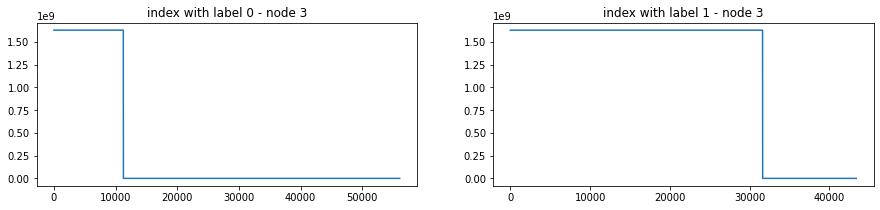

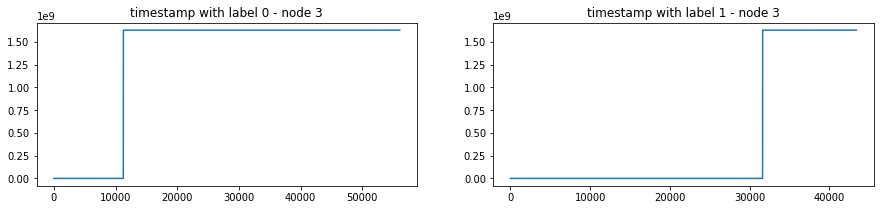

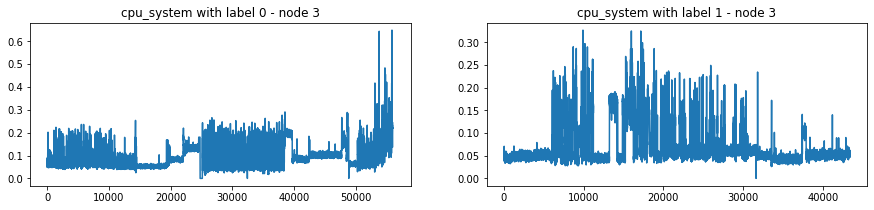

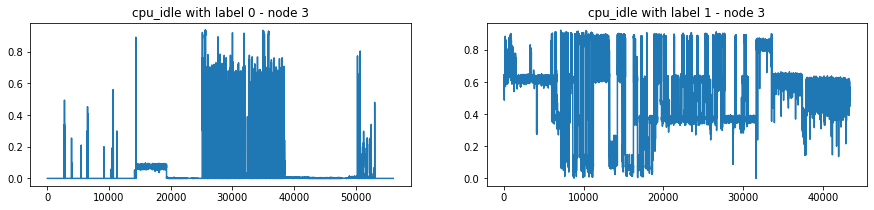

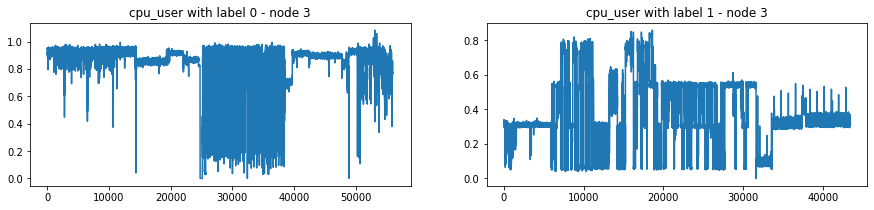

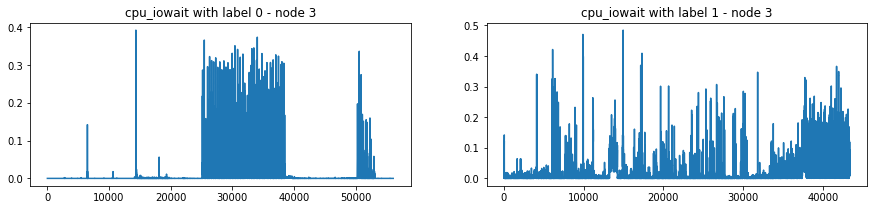

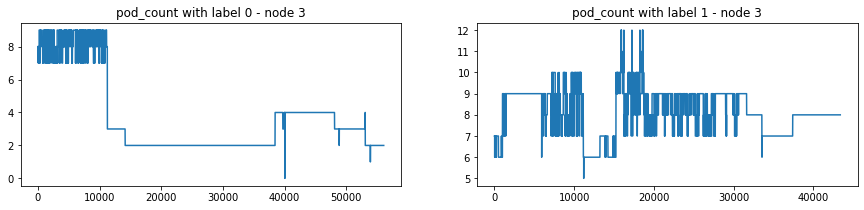

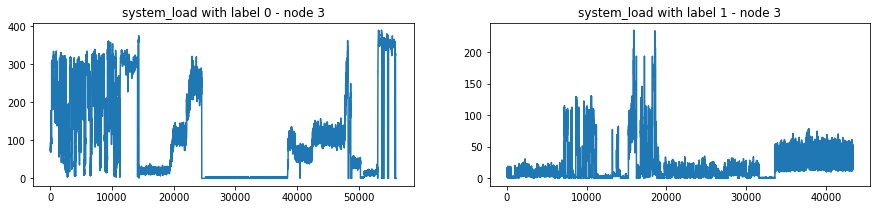

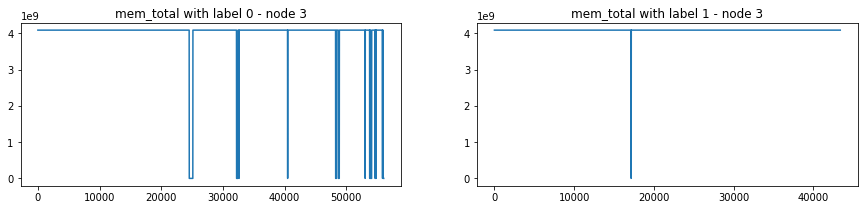

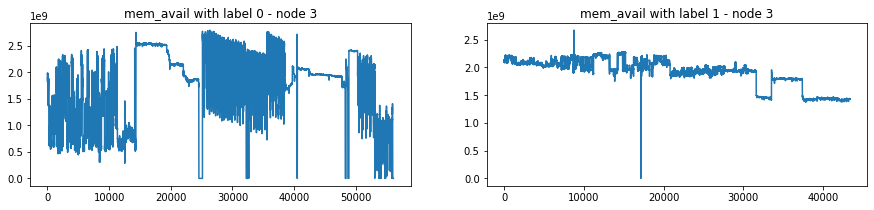

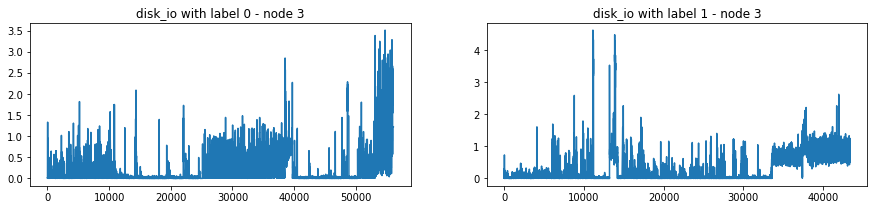

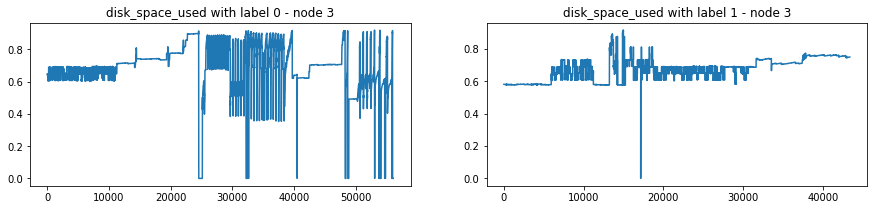

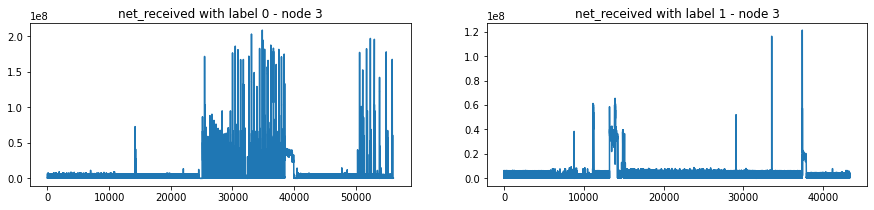

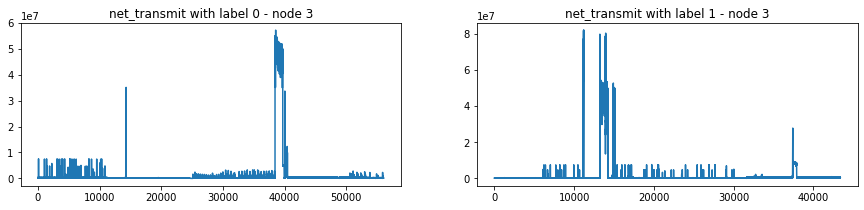

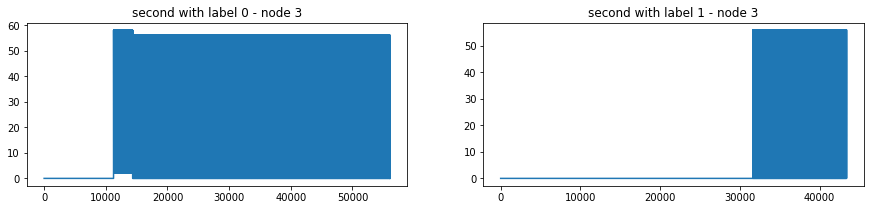

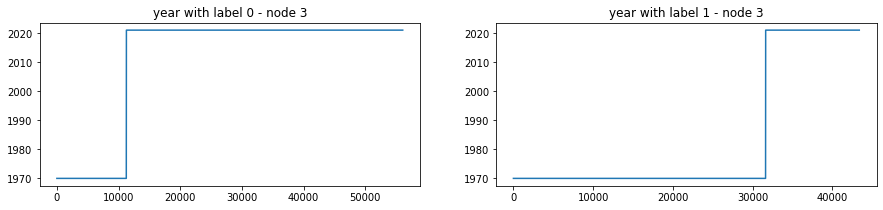

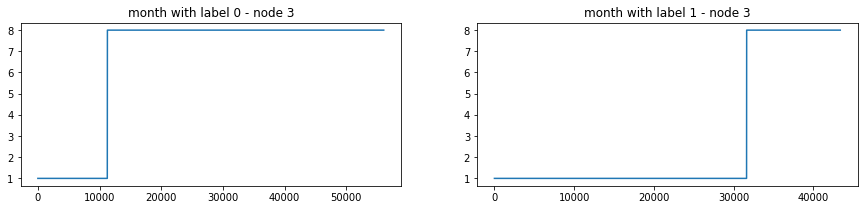

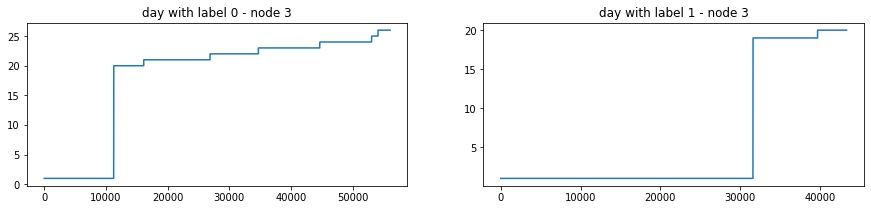

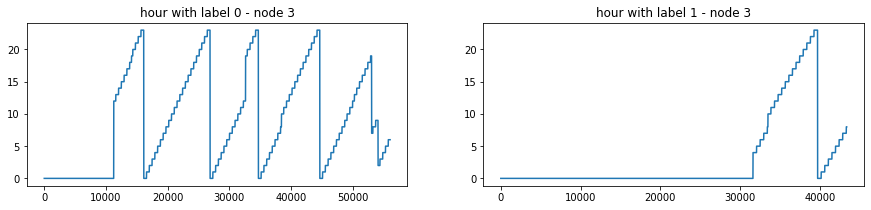

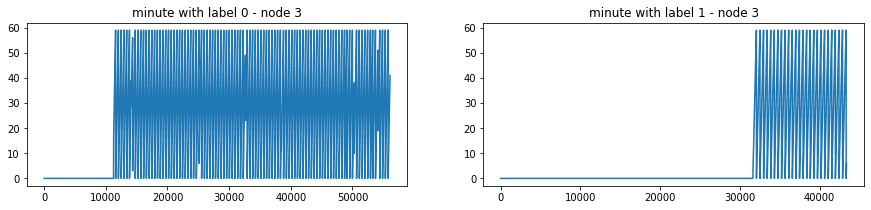

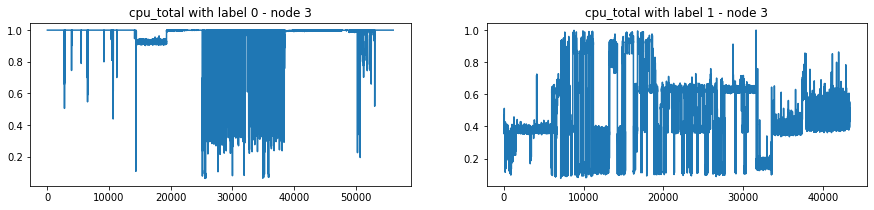

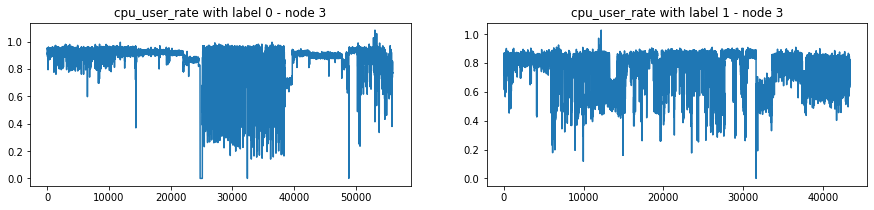

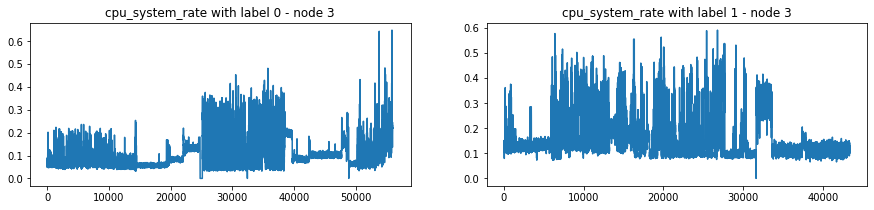

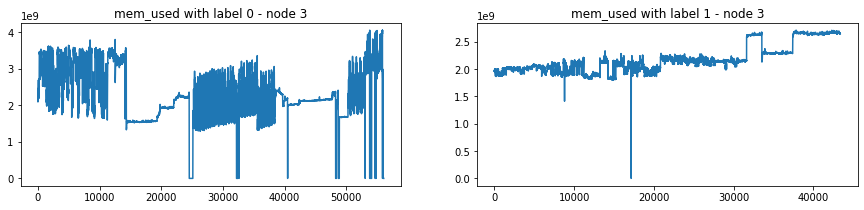

In [191]:
viewAllMetricsByNode(dataset,3)

# Make data becomes budgets
## CPU, Disk Space Used, Pod Count

In [192]:
cpuMax=1
cpuMin=0
cpuStep=5

dataset['cpu_system_bg'] = dataset['cpu_system'].apply(lambda x: groupDataSubset(x,cpuMax,cpuMin,cpuStep))
dataset['cpu_total_bg'] = dataset['cpu_total'].apply(lambda x: groupDataSubset(x,cpuMax,cpuMin,cpuStep))
dataset['cpu_idle_bg'] = dataset['cpu_idle'].apply(lambda x: groupDataSubset(x,cpuMax,cpuMin,cpuStep))
dataset['cpu_user_bg'] = dataset['cpu_user'].apply(lambda x: groupDataSubset(x,cpuMax,cpuMin,cpuStep))
dataset['cpu_iowait_bg'] = dataset['cpu_iowait'].apply(lambda x: groupDataSubset(x,cpuMax,cpuMin,cpuStep))

diskMax=1
diskMin=0
step=5

dataset['disk_space_used_bg'] = dataset['disk_space_used'].apply(lambda x: groupDataSubset(x,diskMax,diskMin,step))

podCountMax = dataset["pod_count"].max()
podCountMin = dataset["pod_count"].min()

dataset['pod_count_bg'] = dataset['pod_count'].apply(lambda x: groupDataSubset(x,podCountMax,podCountMin,step))


## RAM

In [193]:
def updateMemTotal(n,maxValue,row):
    if row["node"]==n:
        return maxValue
    return row["mem_total"]

for n in list(dataset["node"].unique()):
    cksn = dataset[dataset["node"]==n]
    maxValue = dataset["mem_total"].max()
    dataset["mem_total"] = dataset.apply(lambda row: updateMemTotal(n,maxValue,row), axis=1)

dataset["mem_used_rate"] = dataset["mem_used"] / dataset["mem_total"]
dataset["mem_avail_rate"] = dataset["mem_avail"] / dataset["mem_total"]

memMax=1
memMin=0
step=5
dataset['mem_used_rate_bg'] = dataset['mem_used_rate'].apply(lambda x: groupDataSubset(x,memMax,memMin,step))


## Net receive - Net Transmit - System Load - Disk IO - spit with 10 budgets => Not sure

In [270]:
def groupWithItsMaxMin(colName,step):
    vMax = dataset[colName].max()
    vMin = dataset[colName].min()
    dataset[colName+'_bg'] = dataset[colName].apply(lambda x: groupDataSubset(x,vMax,vMin,step))

groupWithItsMaxMin('net_received',10)
groupWithItsMaxMin('net_transmit',10)
groupWithItsMaxMin('disk_io',10)
groupWithItsMaxMin('system_load',10)

--- index
-------Label=0:max 1630328100.0  min: 4546.0
-------Label=1:max 1630656540.0  min: 88534.0
--- timestamp
-------Label=0:max 1629960060.0  min: 0.0
-------Label=1:max 1629446816.0  min: 0.0
--- cpu_system
-------Label=0:max 0.6477777777778101  min: 0.0
-------Label=1:max 0.32666666666627864  min: 0.0
--- cpu_idle
-------Label=0:max 0.9373333333333373  min: 0.0
-------Label=1:max 0.9233333333337215  min: 0.0
--- cpu_user
-------Label=0:max 1.0839999999986807  min: 0.0
-------Label=1:max 0.857999999995809  min: 0.0
--- cpu_iowait
-------Label=0:max 0.3926666666666885  min: 0.0
-------Label=1:max 0.48466666666666547  min: 0.0
--- pod_count
-------Label=0:max 9.0  min: 0.0
-------Label=1:max 12.0  min: 5.0
--- system_load
-------Label=0:max 389.44  min: 0.0
-------Label=1:max 235.07  min: 0.0
--- mem_total
-------Label=0:max 4086054912.0  min: 4086054912.0
-------Label=1:max 4086054912.0  min: 4086054912.0
--- mem_avail
-------Label=0:max 2799693824.0  min: 0.0
-------Label=1:max 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- cpu_system_rate
-------Label=0:max 0.6477777777778101  min: 0.0
-------Label=1:max 0.5904761904760164  min: 0.0
--- mem_used
-------Label=0:max 4056338432.0  min: 0.0
-------Label=1:max 2713276416.0  min: 0.0
--- cpu_system_bg
-------Label=0:max 4  min: 0
-------Label=1:max 2  min: 0
--- cpu_total_bg
-------Label=0:max 5  min: 1
-------Label=1:max 5  min: 1
--- cpu_idle_bg
-------Label=0:max 5  min: 0
-------Label=1:max 5  min: 0
--- cpu_user_bg
-------Label=0:max 5  min: 0
-------Label=1:max 5  min: 0
--- cpu_iowait_bg
-------Label=0:max 2  min: 0
-------Label=1:max 3  min: 0
--- disk_space_used_bg
-------Label=0:max 5  min: 0
-------Label=1:max 5  min: 0
--- pod_count_bg
-------Label=0:max 2  min: 0
-------Label=1:max 3  min: 1
--- mem_used_rate
-------Label=0:max 0.9927273419863428  min: 0.0
-------Label=1:max 0.6640332727863252  min: 0.0
--- mem_avail_rate
-------Label=0:max 0.6851826234096386  min: 0.0
-------Label=1:max 0.6541703255504364  min: 0.0
--- mem_used_rate_bg
------

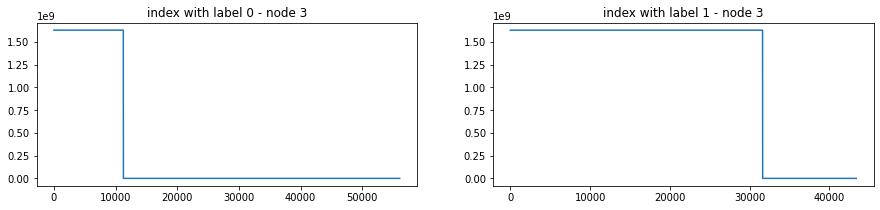

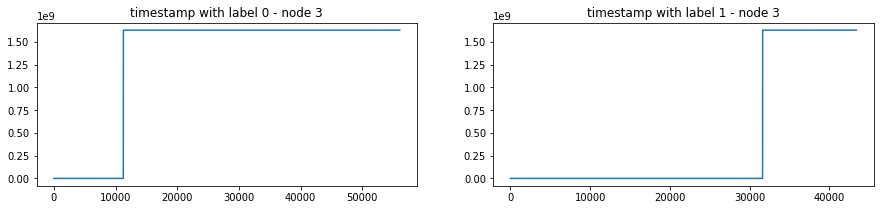

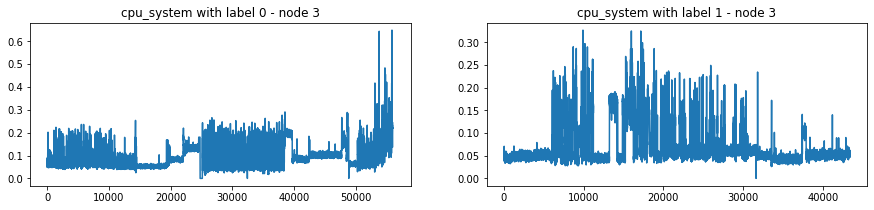

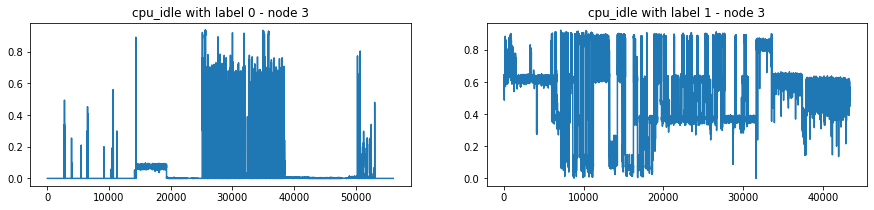

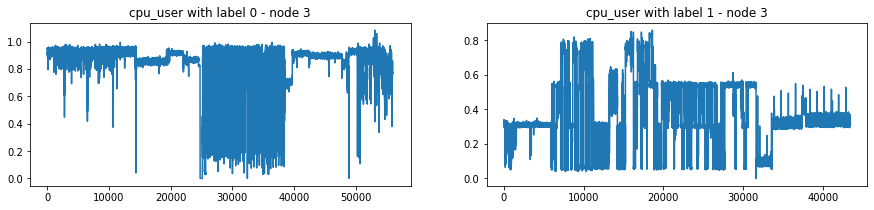

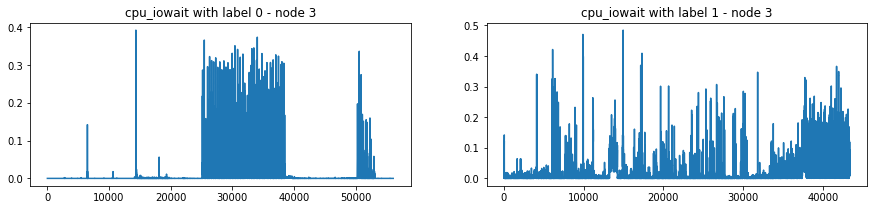

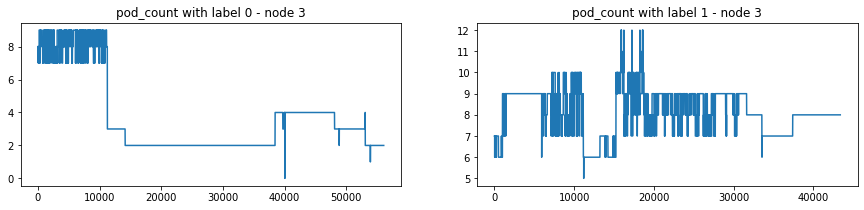

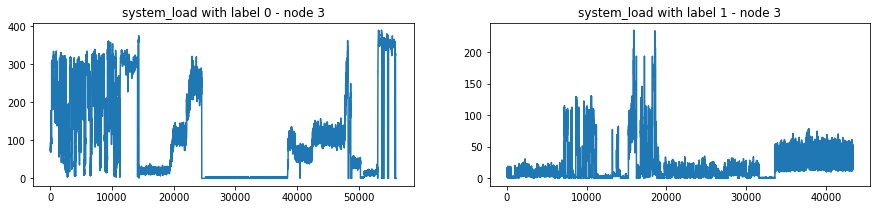

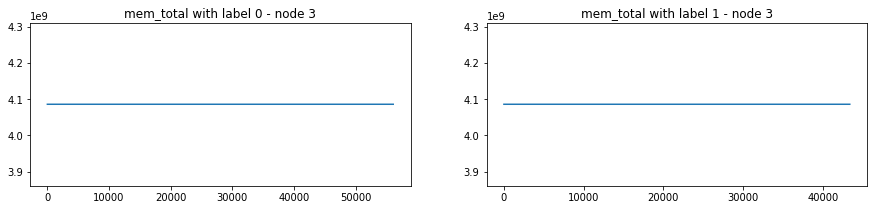

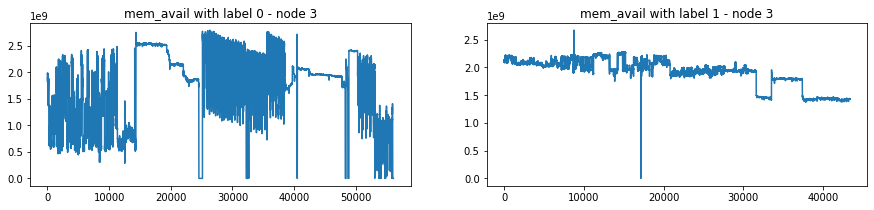

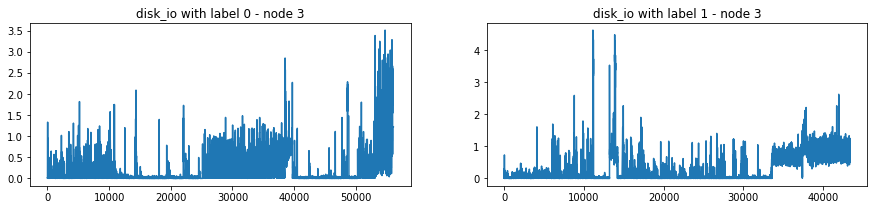

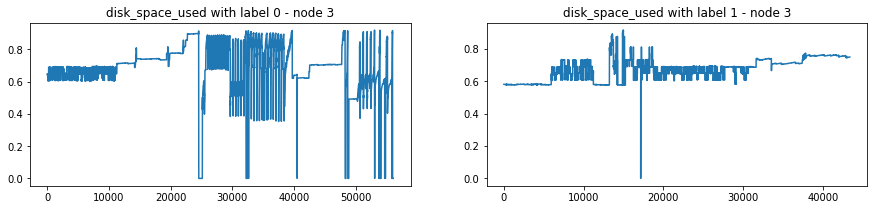

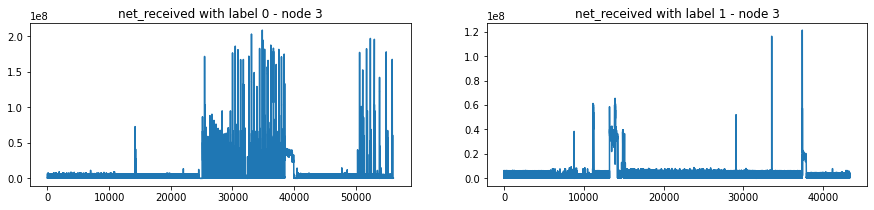

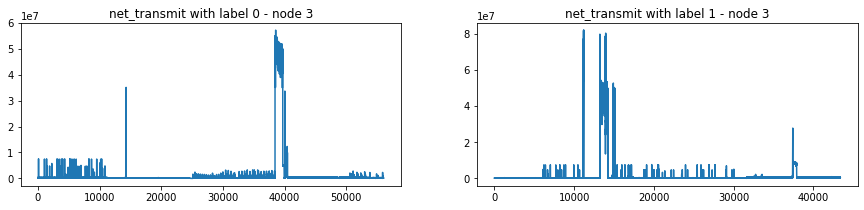

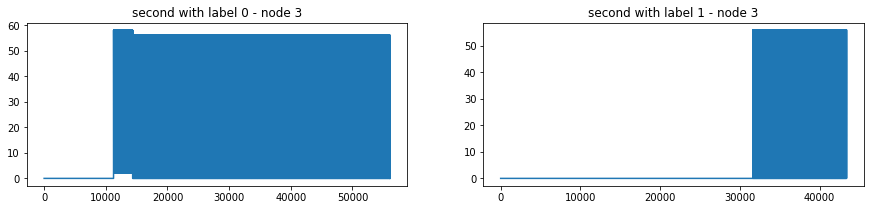

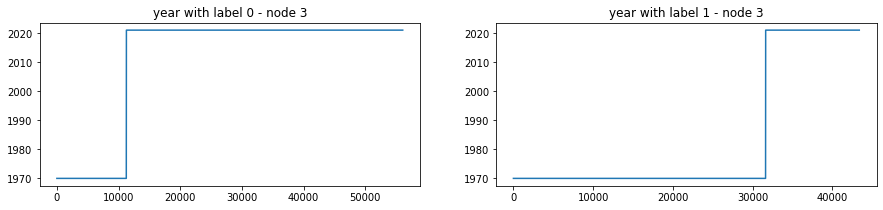

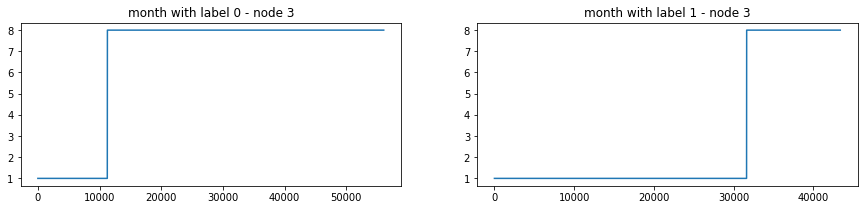

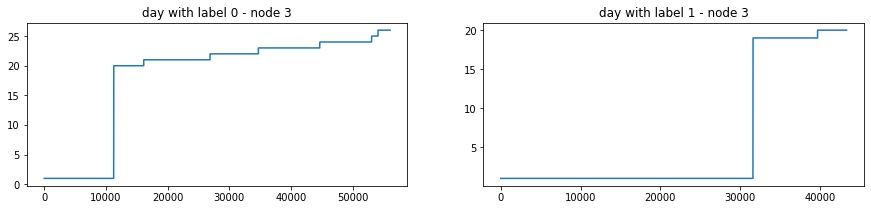

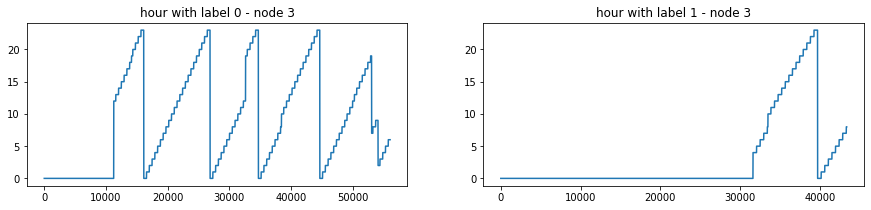

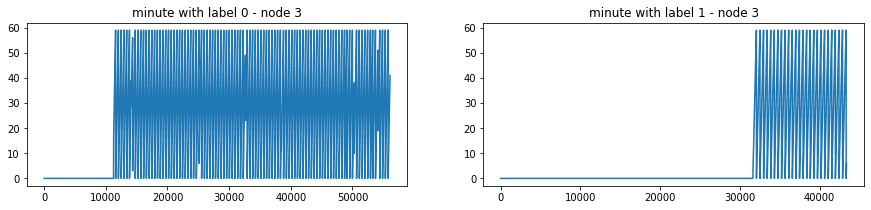

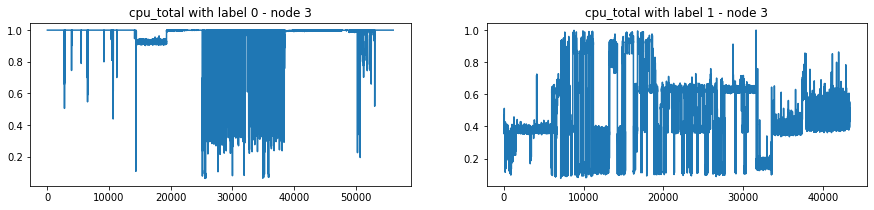

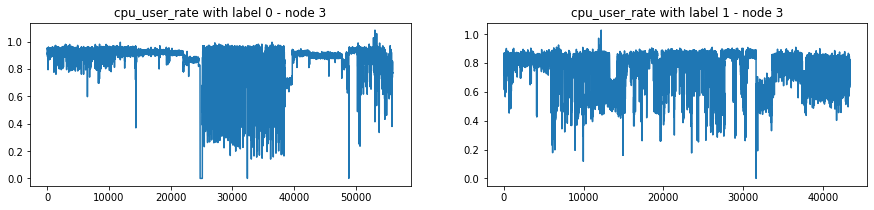

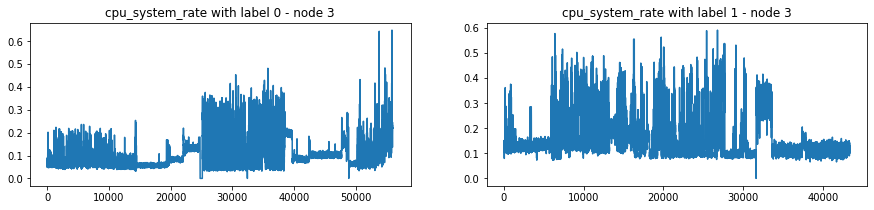

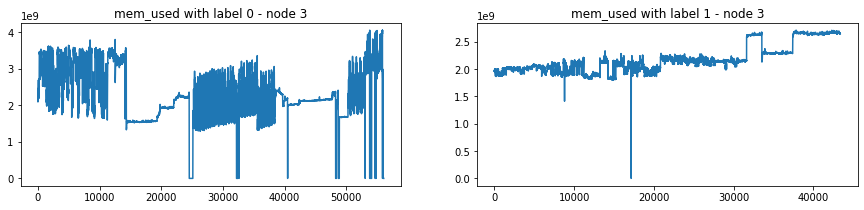

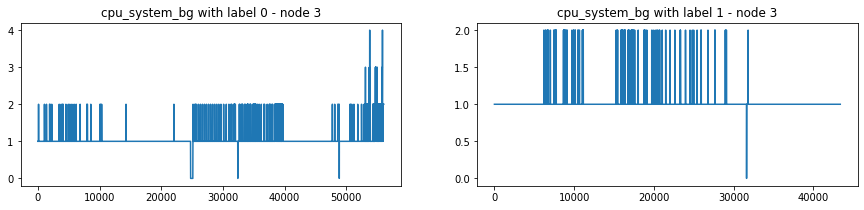

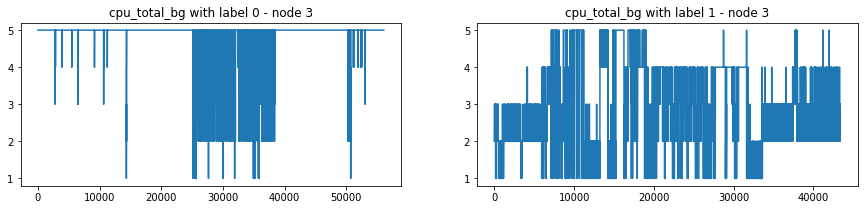

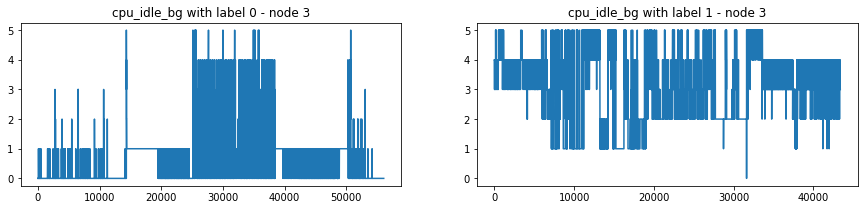

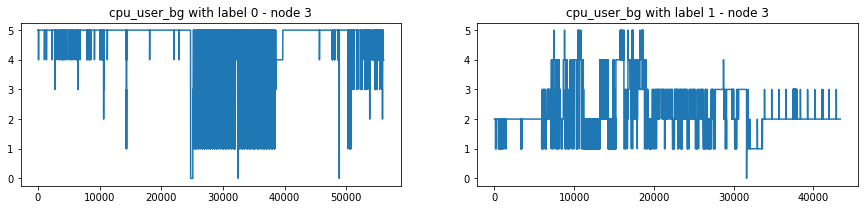

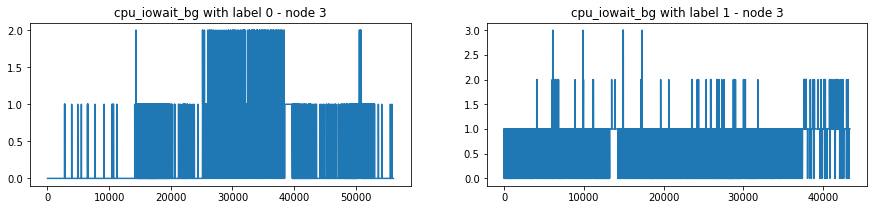

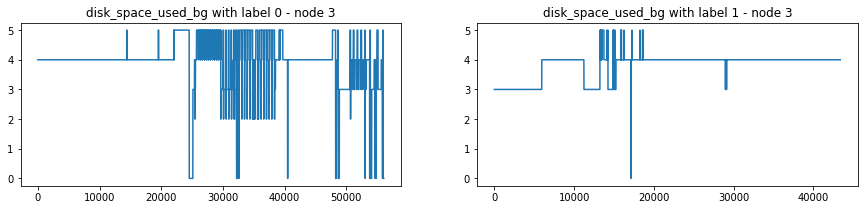

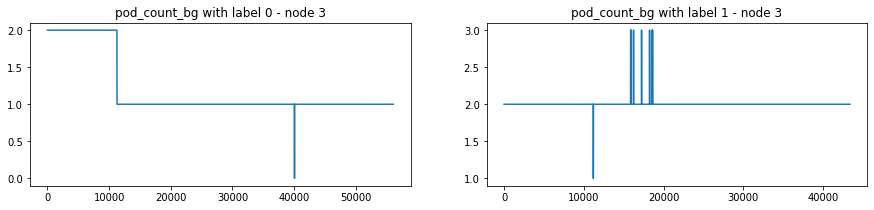

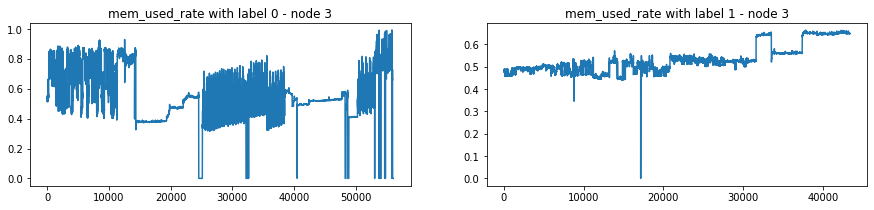

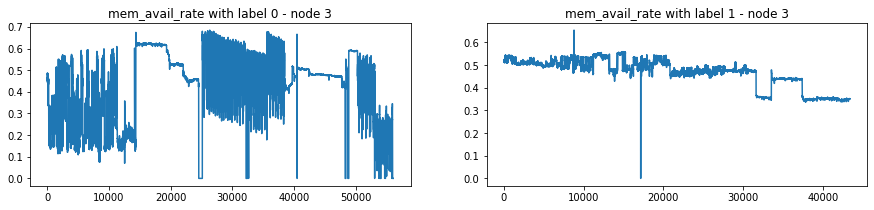

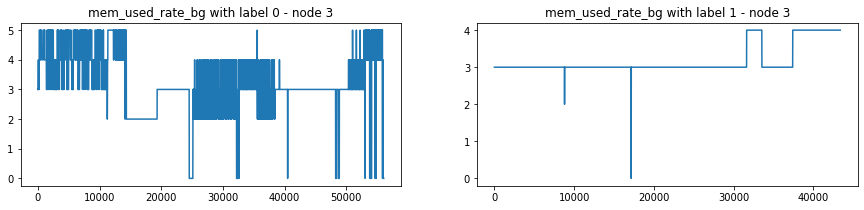

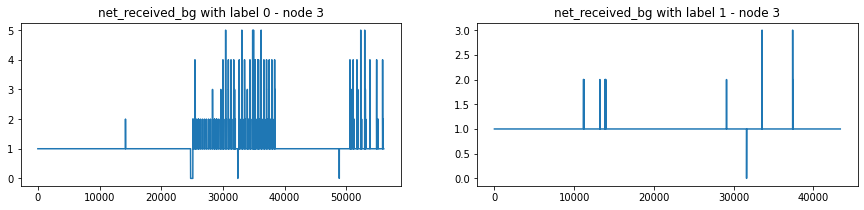

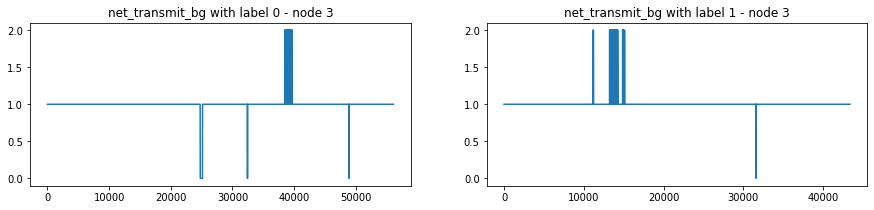

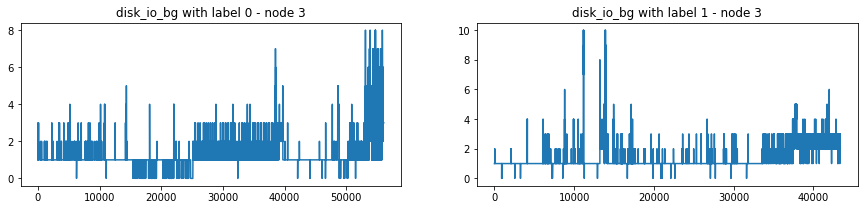

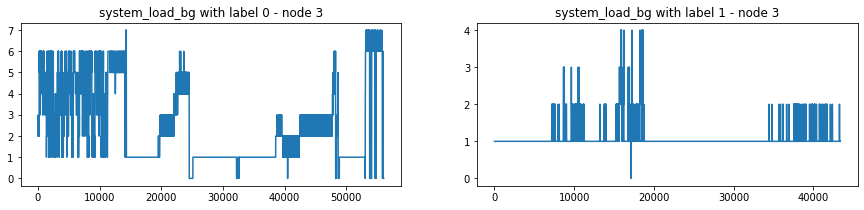

In [271]:
viewAllMetricsByNode(dataset,3)

In [272]:
list(dataset.columns.values)

['index',
 'timestamp',
 'cpu_system',
 'cpu_idle',
 'cpu_user',
 'cpu_iowait',
 'pod_count',
 'system_load',
 'mem_total',
 'mem_avail',
 'disk_io',
 'disk_space_used',
 'net_received',
 'net_transmit',
 'node',
 'label',
 'second',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'cpu_total',
 'cpu_user_rate',
 'cpu_system_rate',
 'mem_used',
 'cpu_system_bg',
 'cpu_total_bg',
 'cpu_idle_bg',
 'cpu_user_bg',
 'cpu_iowait_bg',
 'disk_space_used_bg',
 'pod_count_bg',
 'mem_used_rate',
 'mem_avail_rate',
 'mem_used_rate_bg',
 'net_received_bg',
 'net_transmit_bg',
 'disk_io_bg',
 'system_load_bg']

## Normalize data

In [122]:
datasetnorm = normalizeColumn(dataset)
# datasetnorm = dataset

0   index
1   timestamp
2   cpu_system
3   cpu_idle
4   cpu_user
5   cpu_iowait
6   pod_count
7   system_load
8   mem_total
9   mem_avail
10   disk_io
11   disk_space_used
12   net_received
13   net_transmit


In [53]:
nDatasetNormKnn = datasetnorm.drop("year", axis=1).drop("month", axis=1).drop("day", axis=1).drop("hour", axis=1).drop("minute", axis=1).drop("second", axis=1).drop("timestamp", axis=1).drop("node", axis=1).drop("index", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("cpu_system", axis=1).drop("cpu_idle", axis=1).drop("cpu_user", axis=1).drop("cpu_iowait", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("cpu_user_rate", axis=1).drop("cpu_system_rate", axis=1).drop("cpu_total", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("pod_count", axis=1).drop("disk_space_used", axis=1)

In [54]:
nDatasetNormKnn

system_load  mem_total  mem_avail   disk_io  net_received  \
0         -0.427954  -0.940106   1.026640 -0.320977     -0.247751   
1         -0.427954  -0.940106   1.026640 -0.320977     -0.247751   
2         -0.428214  -0.939579   1.026093 -0.302178     -0.268319   
3         -0.428214  -0.939579   1.026093 -0.302178     -0.268319   
4         -0.428605  -0.940810   1.027369 -0.336016     -0.259478   
...             ...        ...        ...       ...           ...   
295507    -0.429517  -5.259213  -4.063134 -0.338836     -0.356489   
295508    -0.429517  -5.259213  -4.063134 -0.338836     -0.356489   
295509    -0.429517  -5.259213  -4.063134 -0.338836     -0.356489   
295510    -0.429517  -5.259213  -4.063134 -0.338836     -0.356489   
295511    -0.429517  -5.259213  -4.063134 -0.338836     -0.356489   

        net_transmit  label  cpu_system_bg  cpu_total_bg  cpu_idle_bg  \
0          -0.288293      1              1             1            5   
1          -0.288293      1              1             1            5   
2          -0.339613      1              1             1            5   
3          -0.339613      1              1             1            5   
4          -0.306701      1              1             1            5   
...              ...    ...            ...           ...          ...   
295507     -0.417469      0              5             5            5   
295508     -0.417469      0              5             5            5   
295509     -0.417469      0              5             5            5   
295510     -0.417469      0              5             5            5   
295511     -0.417469      0              5             5            5   

        cpu_user_bg  cpu_iowait_bg  disk_space_used_bg  pod_count_bg  
0                 1              1                   3             2  
1                 1              1                   3             2  
2                 1              1                   3             2  
3                 1              1                   3             2  
4                 1              5                   3             2  
...             ...            ...                 ...           ...  
295507            5              5                   5             1  
295508            5              5                   5             1  
295509            5              5                   5             1  
295510            5              5                   5             1  
295511            5              5                   5             1  

[295512 rows x 14 columns]

In [50]:
dataset

index     timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  \
0            0.0  1.629576e+09    0.024000  0.906000  0.052667    0.000333   
1            1.0  1.629576e+09    0.024000  0.906000  0.052667    0.000333   
2            2.0  1.629576e+09    0.034333  0.895667  0.045667    0.003000   
3            3.0  1.629576e+09    0.034333  0.895667  0.045667    0.003000   
4            4.0  1.629576e+09    0.025000  0.908000  0.045000    0.000000   
...          ...           ...         ...       ...       ...         ...   
295507  170125.0  1.629576e+09    0.000000  0.000000  0.000000    0.000000   
295508  170126.0  1.629576e+09    0.000000  0.000000  0.000000    0.000000   
295509  170127.0  1.629576e+09    0.000000  0.000000  0.000000    0.000000   
295510  170128.0  1.629576e+09    0.000000  0.000000  0.000000    0.000000   
295511  170129.0  1.629576e+09    0.000000  0.000000  0.000000    0.000000   

        pod_count  system_load     mem_total     mem_avail  ...  cpu_total  \
0             6.0         0.12  1.911521e+09  2.174521e+09  ...   0.094000   
1             6.0         0.12  1.911521e+09  2.174521e+09  ...   0.094000   
2             6.0         0.10  1.911755e+09  2.174288e+09  ...   0.104333   
3             6.0         0.10  1.911755e+09  2.174288e+09  ...   0.104333   
4             6.0         0.07  1.911210e+09  2.174833e+09  ...   0.092000   
...           ...          ...           ...           ...  ...        ...   
295507        2.0         0.00  0.000000e+00  0.000000e+00  ...   1.000000   
295508        2.0         0.00  0.000000e+00  0.000000e+00  ...   1.000000   
295509        2.0         0.00  0.000000e+00  0.000000e+00  ...   1.000000   
295510        2.0         0.00  0.000000e+00  0.000000e+00  ...   1.000000   
295511        2.0         0.00  0.000000e+00  0.000000e+00  ...   1.000000   

        cpu_user_rate  cpu_system_rate  cpu_system_bg  cpu_total_bg  \
0            0.560284         0.255319              1             1   
1            0.560284         0.255319              1             1   
2            0.437700         0.329073              1             1   
3            0.437700         0.329073              1             1   
4            0.489130         0.271739              1             1   
...               ...              ...            ...           ...   
295507       0.000000         0.000000              5             5   
295508       0.000000         0.000000              5             5   
295509       0.000000         0.000000              5             5   
295510       0.000000         0.000000              5             5   
295511       0.000000         0.000000              5             5   

        cpu_idle_bg  cpu_user_bg  cpu_iowait_bg  disk_space_used_bg  \
0                 5            1              1                   3   
1                 5            1              1                   3   
2                 5            1              1                   3   
3                 5            1              1                   3   
4                 5            1              5                   3   
...             ...          ...            ...                 ...   
295507            5            5              5                   5   
295508            5            5              5                   5   
295509            5            5              5                   5   
295510            5            5              5                   5   
295511            5            5              5                   5   

        pod_count_bg  
0                  2  
1                  2  
2                  2  
3                  2  
4                  2  
...              ...  
295507             1  
295508             1  
295509             1  
295510             1  
295511             1  

[295512 rows x 32 columns]

## Overview of data

In [51]:
def mergeWithDiff(df):
    nodeList = df['node'].unique()
    lsDfn = []
    dperiod = 5
    for n in nodeList:
#         print("Node:",n)
        dfn = df[df['node']==n]
        dfn = dfn.sort_values(by=['timestamp'])
        dfn = dfn.diff(periods=dperiod).add_prefix('diff_')
#         print(dfn)
        lsDfn.append(dfn)
    dffn = pd.concat(lsDfn)
    dn = pd.concat([df, dffn], axis=1)
    dn = dn.fillna(0)
    return dn

In [400]:
# datasetnormwdiff = mergeWithDiff(datasetnorm)

In [52]:
datasetnorm

index  timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  \
0      -0.878143   0.877994   -1.109678  1.088068 -1.019622   -0.247345   
1      -0.878143   0.877994   -1.109678  1.088068 -1.019622   -0.247345   
2      -0.878143   0.877994   -0.906071  1.058422 -1.041554   -0.150130   
3      -0.878143   0.877994   -0.906071  1.058422 -1.041554   -0.150130   
4      -0.878143   0.877994   -1.089974  1.093806 -1.043642   -0.259497   
...          ...        ...         ...       ...       ...         ...   
295507 -0.877933   0.877993   -1.582572 -1.511253 -1.184634   -0.259497   
295508 -0.877933   0.877993   -1.582572 -1.511253 -1.184634   -0.259497   
295509 -0.877933   0.877993   -1.582572 -1.511253 -1.184634   -0.259497   
295510 -0.877933   0.877993   -1.582572 -1.511253 -1.184634   -0.259497   
295511 -0.877933   0.877993   -1.582572 -1.511253 -1.184634   -0.259497   

        pod_count  system_load  mem_total  mem_avail  ...  cpu_total  \
0       -0.665480    -0.427954  -0.940106   1.026640  ...   0.094000   
1       -0.665480    -0.427954  -0.940106   1.026640  ...   0.094000   
2       -0.665480    -0.428214  -0.939579   1.026093  ...   0.104333   
3       -0.665480    -0.428214  -0.939579   1.026093  ...   0.104333   
4       -0.665480    -0.428605  -0.940810   1.027369  ...   0.092000   
...           ...          ...        ...        ...  ...        ...   
295507  -1.503167    -0.429517  -5.259213  -4.063134  ...   1.000000   
295508  -1.503167    -0.429517  -5.259213  -4.063134  ...   1.000000   
295509  -1.503167    -0.429517  -5.259213  -4.063134  ...   1.000000   
295510  -1.503167    -0.429517  -5.259213  -4.063134  ...   1.000000   
295511  -1.503167    -0.429517  -5.259213  -4.063134  ...   1.000000   

        cpu_user_rate  cpu_system_rate  cpu_system_bg  cpu_total_bg  \
0            0.560284         0.255319              1             1   
1            0.560284         0.255319              1             1   
2            0.437700         0.329073              1             1   
3            0.437700         0.329073              1             1   
4            0.489130         0.271739              1             1   
...               ...              ...            ...           ...   
295507       0.000000         0.000000              5             5   
295508       0.000000         0.000000              5             5   
295509       0.000000         0.000000              5             5   
295510       0.000000         0.000000              5             5   
295511       0.000000         0.000000              5             5   

        cpu_idle_bg  cpu_user_bg  cpu_iowait_bg  disk_space_used_bg  \
0                 5            1              1                   3   
1                 5            1              1                   3   
2                 5            1              1                   3   
3                 5            1              1                   3   
4                 5            1              5                   3   
...             ...          ...            ...                 ...   
295507            5            5              5                   5   
295508            5            5              5                   5   
295509            5            5              5                   5   
295510            5            5              5                   5   
295511            5            5              5                   5   

        pod_count_bg  
0                  2  
1                  2  
2                  2  
3                  2  
4                  2  
...              ...  
295507             1  
295508             1  
295509             1  
295510             1  
295511             1  

[295512 rows x 32 columns]

--- index
-------Label=0:max 1.138934257721388  min: -0.8781377349897448
-------Label=1:max 1.139340610879729  min: -0.8780338231974456
--- timestamp
-------Label=0:max 0.8784687348271285  min: -1.138898562035052
-------Label=1:max 0.8778335035191229  min: -1.138898562035052
--- cpu_system
-------Label=0:max 11.181175544001345  min: -1.5825716986493958
-------Label=1:max 4.854034972593611  min: -1.5825716986493958
--- cpu_idle
-------Label=0:max 1.1779640733739352  min: -1.5112533487622184
-------Label=1:max 1.1377979525607704  min: -1.5112533487622184
--- cpu_user
-------Label=0:max 2.2117008889541503  min: -1.1846341020636766
-------Label=1:max 1.5036089074221246  min: -1.1846341020636766
--- cpu_iowait
-------Label=0:max 14.055398360460492  min: -0.2594972072250956
-------Label=1:max 17.40931277190363  min: -0.2594972072250956
--- pod_count
-------Label=0:max -0.03721461266427863  min: -1.9220104072069017
-------Label=1:max 0.5910506521832624  min: -0.8749016324610001
--- system_loa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- cpu_total_bg
-------Label=0:max 5  min: 1
-------Label=1:max 5  min: 1
--- cpu_idle_bg
-------Label=0:max 5  min: 1
-------Label=1:max 5  min: 1
--- cpu_user_bg
-------Label=0:max 5  min: 1
-------Label=1:max 5  min: 1
--- cpu_iowait_bg
-------Label=0:max 5  min: 1
-------Label=1:max 5  min: 1
--- disk_space_used_bg
-------Label=0:max 5  min: 2
-------Label=1:max 5  min: 3
--- pod_count_bg
-------Label=0:max 5  min: 1
-------Label=1:max 3  min: 1


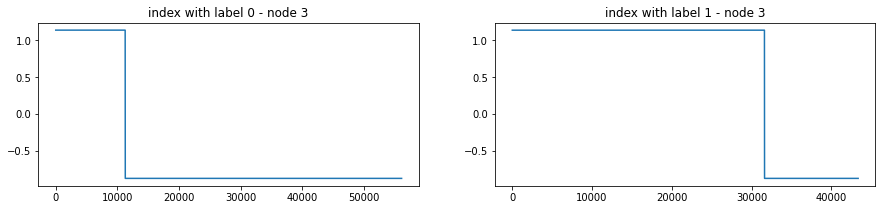

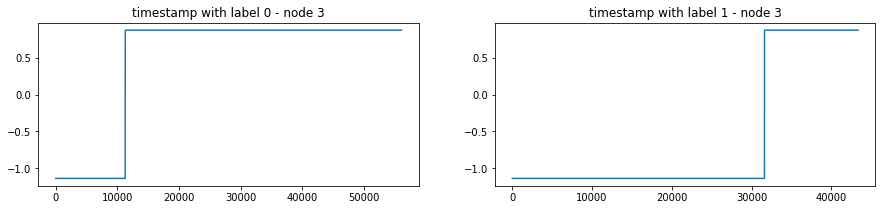

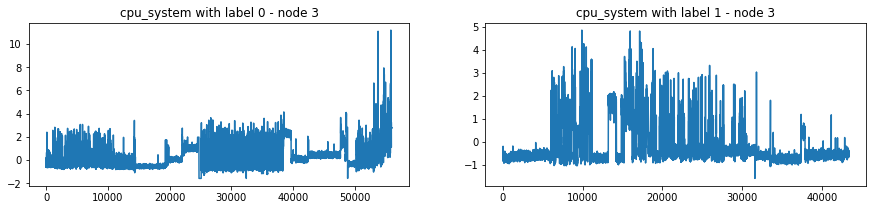

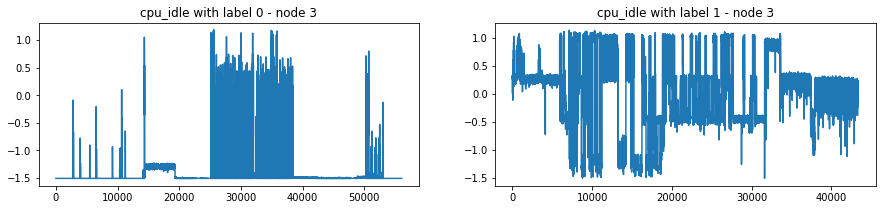

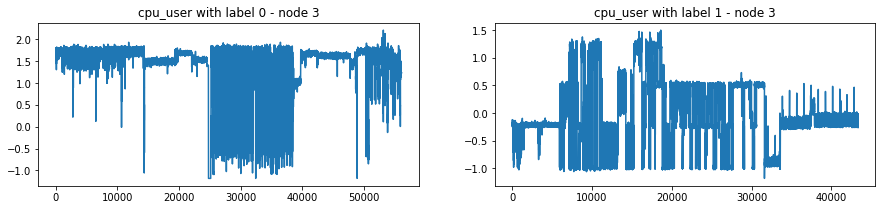

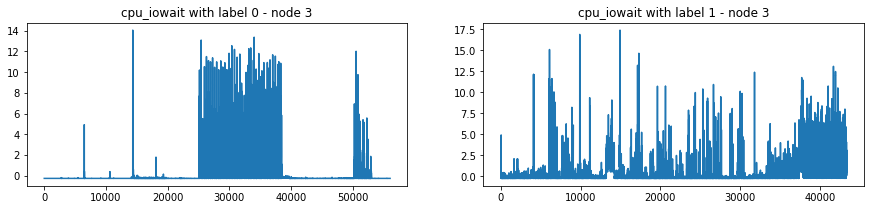

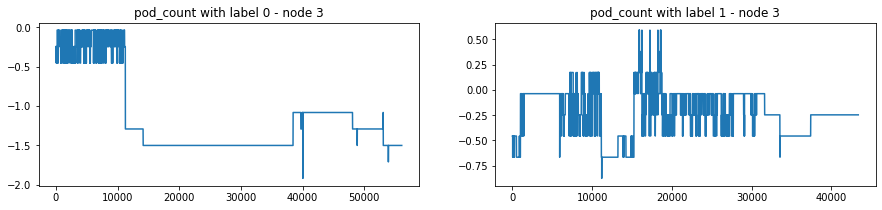

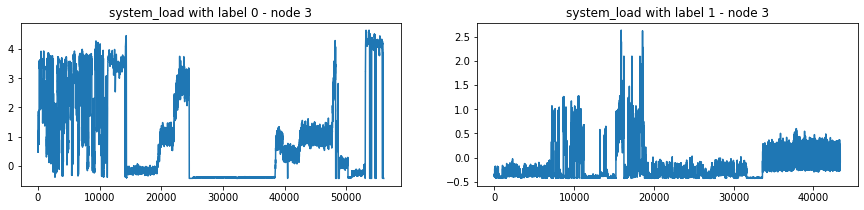

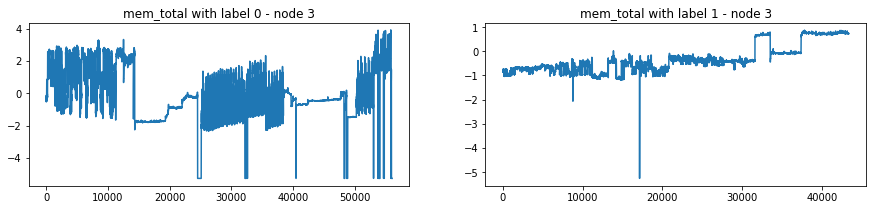

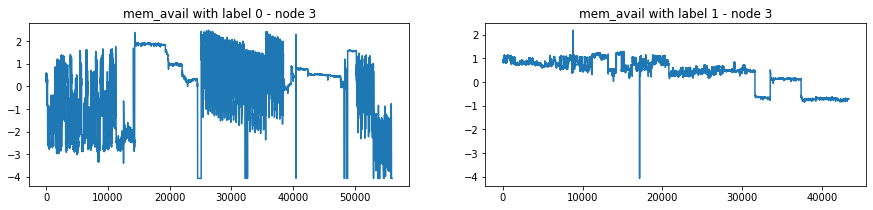

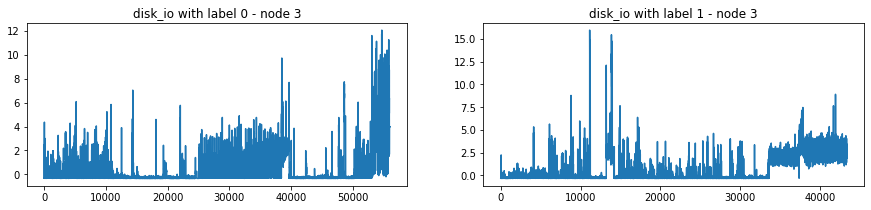

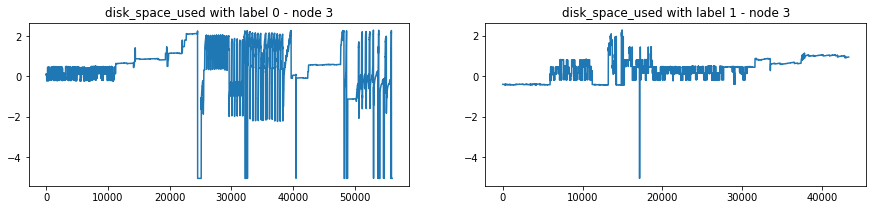

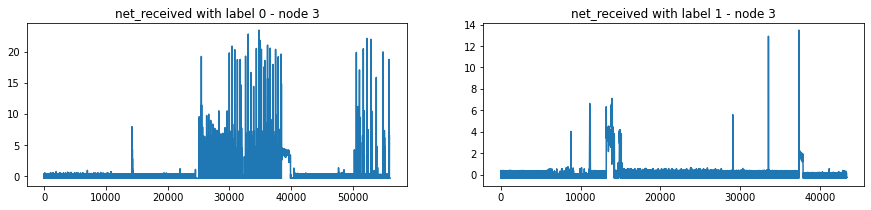

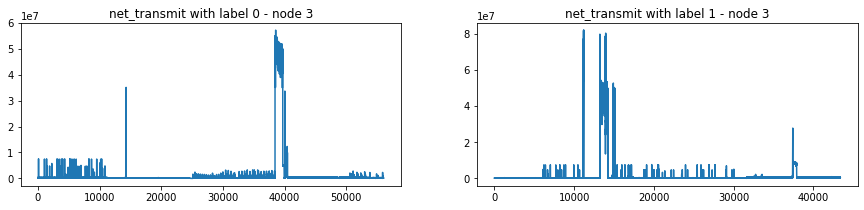

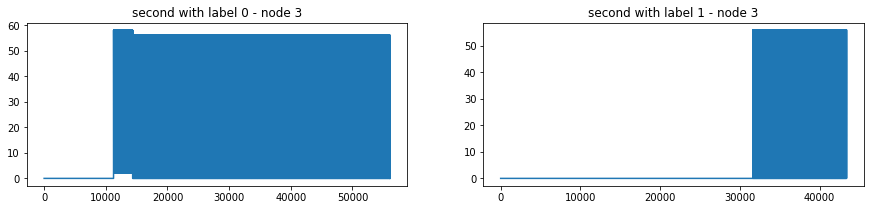

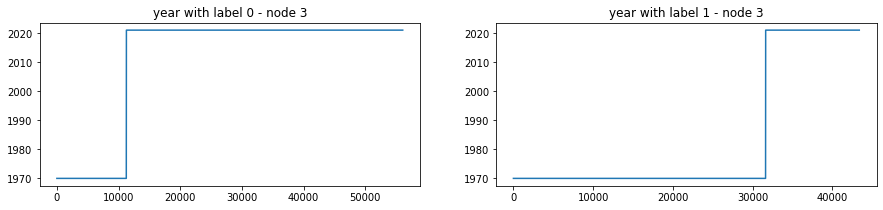

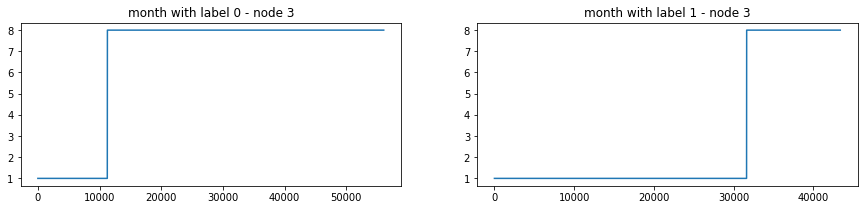

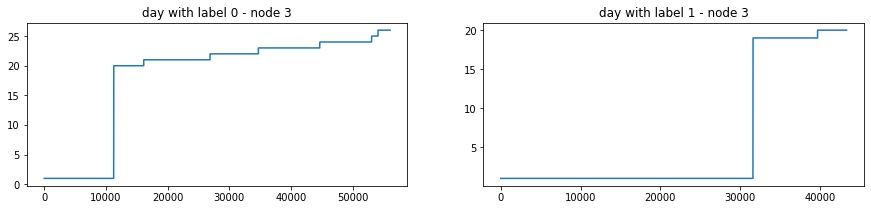

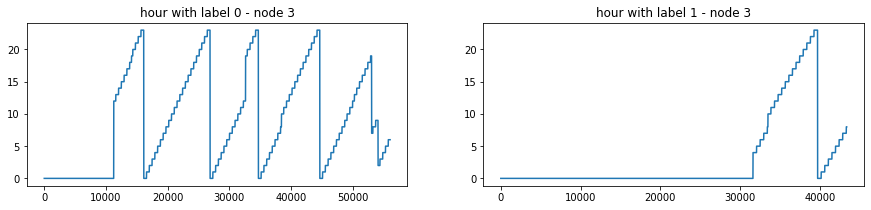

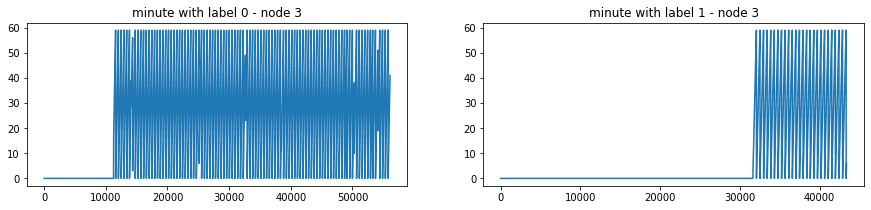

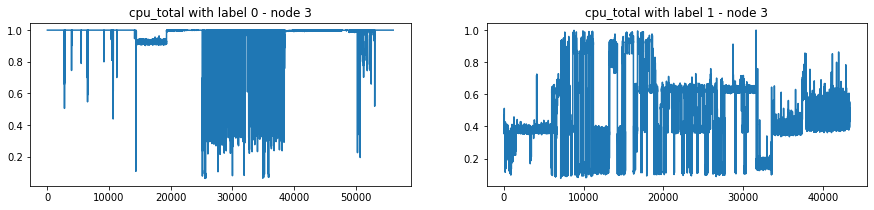

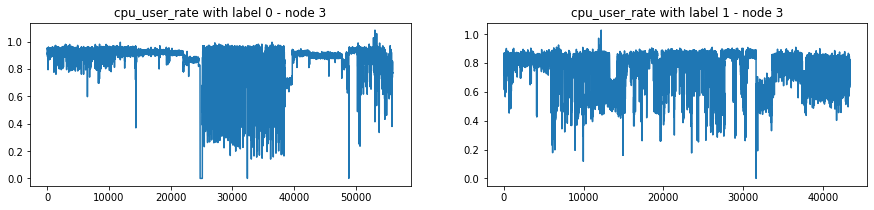

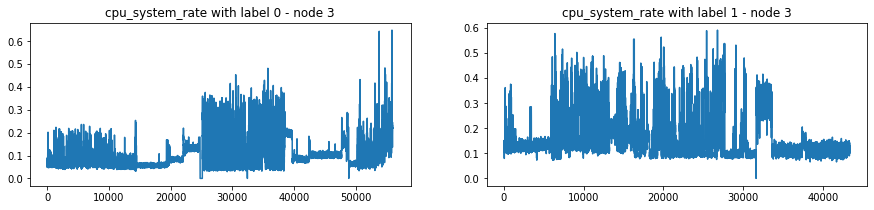

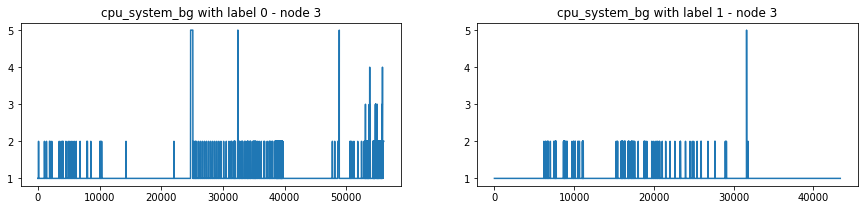

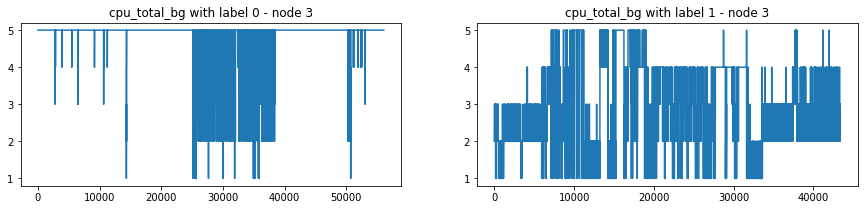

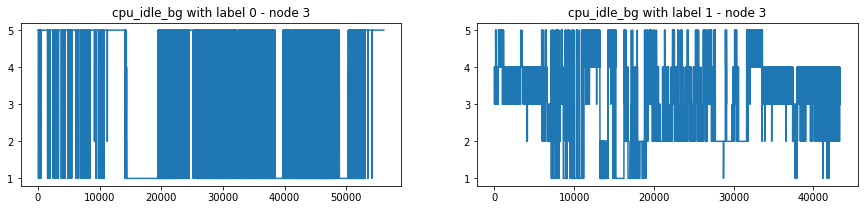

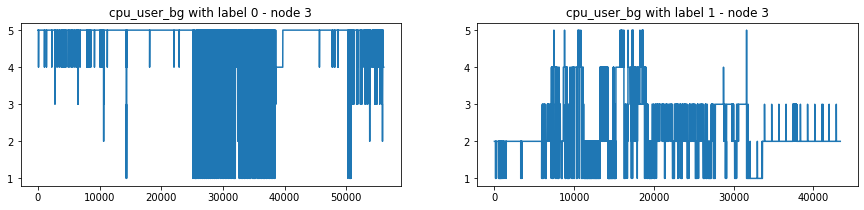

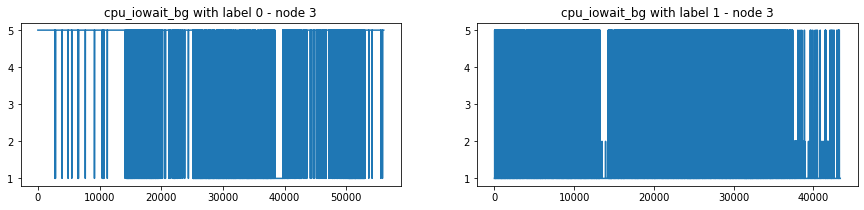

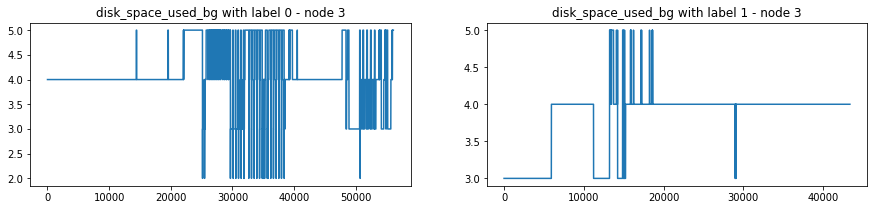

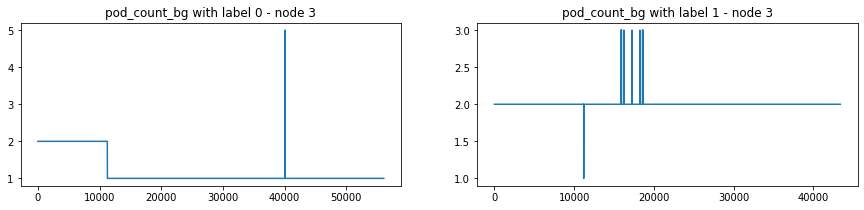

In [469]:
viewAllMetricsByNode(datasetnorm,3)

In [371]:
datasetnorm.groupby('label').mean()

index  timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  \
label                                                                        
-2.066062 -0.473142   0.473222    0.284141 -1.406667  1.474322    -0.03048   
 0.484011  0.110842  -0.110860   -0.066565  0.329536 -0.345385     0.00714   

           pod_count  system_load  mem_total  mem_avail  ...  cpu_total  \
label                                                    ...              
-2.066062  -1.135688     1.027893  -0.222472   0.013847  ...   0.963546   
 0.484011   0.266055    -0.240802   0.052118  -0.003244  ...   0.358388   

           cpu_user_rate  cpu_system_rate  cpu_system_bg  cpu_total_bg  \
label                                                                    
-2.066062       0.873044         0.101297       1.065450      4.892314   
 0.484011       0.691922         0.288109       1.055183      2.220497   

           cpu_idle_bg  cpu_user_bg  cpu_iowait_bg  disk_space_used_bg  \
label                                                                    
-2.066062     2.822675     4.768743       3.807966            4.126638   
 0.484011     3.779507     1.831549       1.992733            3.547103   

           pod_count_bg  
label                    
-2.066062      1.201519  
 0.484011      2.481432  

[2 rows x 31 columns]

In [253]:
datasetnorm.groupby('label').max()

index  timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  \
label                                                                    
0      1.316907   0.759894   12.163066  1.105443  2.259066   14.495308   
1      1.316907   0.759894    7.121009  2.161289  1.451594   21.471875   

       pod_count  system_load  mem_total  mem_avail  ...  node  second  year  \
label                                                ...                       
0       0.075517     5.104001   3.831745   2.416840  ...     3      58  2021   
1       2.562730     0.797955   2.513972   2.053163  ...     3      58  2021   

       month  day  hour  minute  cpu_total  cpu_user_rate  cpu_system_rate  
label                                                                       
0          8   26    23      59        1.0          1.084         0.647778  
1          8   26    23      59        1.0          8.000         6.958333  

[2 rows x 24 columns]

In [254]:
datasetnorm.groupby('label').min()

index  timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  \
label                                                                    
0     -0.759553  -1.316735   -1.611627 -1.591235 -1.110367   -0.259443   
1     -0.759559  -1.316735   -1.611627 -1.591235 -1.110367   -0.259443   

       pod_count  system_load  mem_total  mem_avail  ...  node  second  year  \
label                                                ...                       
0      -1.959475    -0.407376  -5.110006  -3.984753  ...     3       0  1970   
1      -1.959475    -0.407376  -5.110006  -3.984753  ...     1       0  1970   

       month  day  hour  minute  cpu_total  cpu_user_rate  cpu_system_rate  
label                                                                       
0          1    1     0       0   0.062667       0.000000         0.000000  
1          1    1     0       0  -0.304333      -1.977528        -1.573034  

[2 rows x 24 columns]

In [255]:
datasetnorm

index  timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  \
0      -0.759559   0.759405   -1.101278  1.015298 -0.946661   -0.246918   
1      -0.759559   0.759405   -1.101278  1.015298 -0.946661   -0.246918   
2      -0.759559   0.759405   -0.881544  0.985569 -0.968420   -0.146716   
3      -0.759559   0.759405   -0.881544  0.985569 -0.968420   -0.146716   
4      -0.759559   0.759405   -1.080013  1.021051 -0.970492   -0.259443   
...          ...        ...         ...       ...       ...         ...   
263104 -0.759343   0.759405   -1.611627 -1.591235 -1.110367   -0.259443   
263105 -0.759343   0.759405   -1.611627 -1.591235 -1.110367   -0.259443   
263106 -0.759343   0.759405   -1.611627 -1.591235 -1.110367   -0.259443   
263107 -0.759343   0.759405   -1.611627 -1.591235 -1.110367   -0.259443   
263108 -0.759343   0.759405   -1.611627 -1.591235 -1.110367   -0.259443   

        pod_count  system_load  mem_total  mem_avail  ...  label  second  \
0       -0.602814    -0.405678  -0.896268   0.987362  ...      1       0   
1       -0.602814    -0.405678  -0.896268   0.987362  ...      1       8   
2       -0.602814    -0.405961  -0.895753   0.986829  ...      1      16   
3       -0.602814    -0.405961  -0.895753   0.986829  ...      1      24   
4       -0.602814    -0.406385  -0.896954   0.988074  ...      1      32   
...           ...          ...        ...        ...  ...    ...     ...   
263104  -1.507255    -0.407376  -5.110006  -3.984753  ...      0      24   
263105  -1.507255    -0.407376  -5.110006  -3.984753  ...      0      32   
263106  -1.507255    -0.407376  -5.110006  -3.984753  ...      0      40   
263107  -1.507255    -0.407376  -5.110006  -3.984753  ...      0      48   
263108  -1.507255    -0.407376  -5.110006  -3.984753  ...      0      56   

        year  month  day  hour  minute  cpu_total  cpu_user_rate  \
0       2021      8   21    20       6   0.094000       0.560284   
1       2021      8   21    20       6   0.094000       0.560284   
2       2021      8   21    20       6   0.104333       0.437700   
3       2021      8   21    20       6   0.104333       0.437700   
4       2021      8   21    20       6   0.092000       0.489130   
...      ...    ...  ...   ...     ...        ...            ...   
263104  2021      8   21    19      59   1.000000       0.000000   
263105  2021      8   21    19      59   1.000000       0.000000   
263106  2021      8   21    19      59   1.000000       0.000000   
263107  2021      8   21    19      59   1.000000       0.000000   
263108  2021      8   21    19      59   1.000000       0.000000   

        cpu_system_rate  
0              0.255319  
1              0.255319  
2              0.329073  
3              0.329073  
4              0.271739  
...                 ...  
263104         0.000000  
263105         0.000000  
263106         0.000000  
263107         0.000000  
263108         0.000000  

[263109 rows x 25 columns]

In [65]:
correlation_matrix = datasetnorm.corr()
correlation_matrix["label"]

index              0.229007
timestamp         -0.229045
cpu_system        -0.137528
cpu_idle           0.680844
cpu_user          -0.713590
cpu_iowait         0.014753
pod_count          0.549687
system_load       -0.497513
mem_total          0.107679
mem_avail         -0.006702
disk_io           -0.081445
disk_space_used   -0.229305
net_received      -0.037779
net_transmit       0.111801
node              -0.588487
label              1.000000
second            -0.168672
year              -0.229020
month             -0.229020
day               -0.249545
hour              -0.171259
minute            -0.172394
cpu_total         -0.680844
cpu_user_rate     -0.462609
cpu_system_rate    0.467924
Name: label, dtype: float64

<AxesSubplot:>

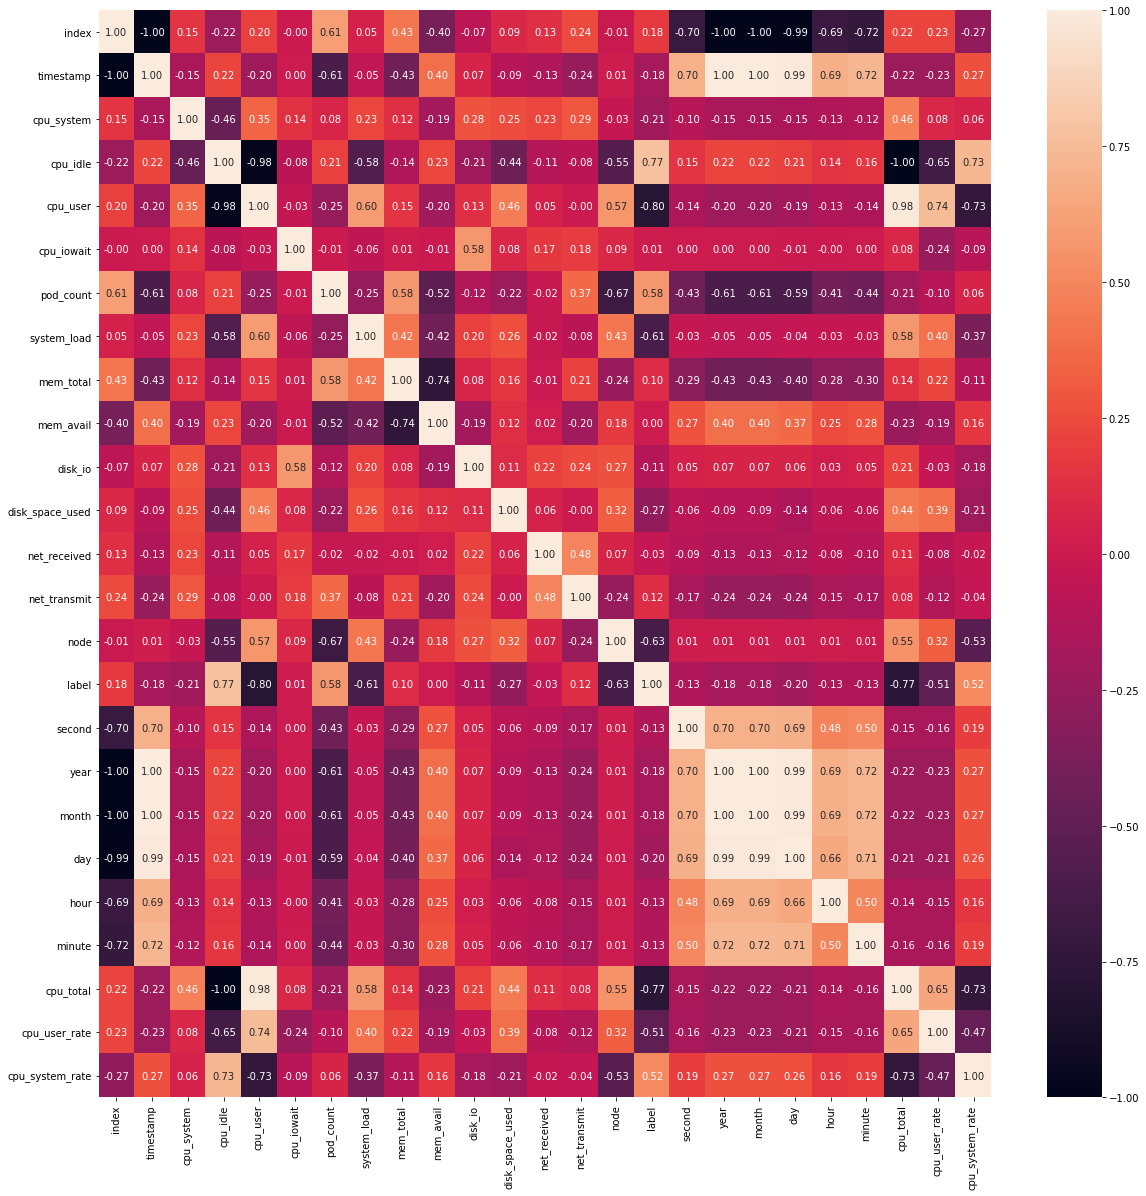

In [20]:
plt.figure(figsize=(20,20))
sn.heatmap(datasetnorm.corr(), annot=True, fmt='.2f')

correlation matrix interpretation:
- CPU Idle (cpu free) increase, label increase and vice versa
- CPU user / CPU total increase, label decrease => If we still have more CPU, label is 1, if users are using more CPU, label is 0
- Pod count increases, label increases
- System load increases, label decrease => System gets more stress => label is 0
- disk space used increase, label decrease => We have less free disk => label is 0

# Rebalance data

In [137]:
def resampleData(dataset,label):
    dataX = dataset.drop(label, axis=1)
    dataY = dataset[label]
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(dataX, dataY)
    result = pd.concat([X_res, y_res], axis=1)
    return result

In [138]:
rsDataset = resampleData(datasetnorm, "label")

In [139]:
print(rsDataset["label"].value_counts())

1    186218
0    186218
Name: label, dtype: int64


--- index
-------Label=0:max 1.3169068780240916  min: -0.7595534423969634
-------Label=1:max 1.3167903391206008  min: -0.7594464711464017
--- timestamp
-------Label=0:max 0.7598941490129197  min: -1.3167354280531822
-------Label=1:max 0.7592402571189971  min: -1.3167354280531822
--- cpu_system
-------Label=0:max 12.163066314874605  min: -1.6116267233948172
-------Label=1:max 3.6832424187604227  min: -1.6116267233948172
--- cpu_idle
-------Label=0:max 1.1054425306833038  min: -1.5912345557969536
-------Label=1:max 1.0306413881703476  min: -1.5912345557969536
--- cpu_user
-------Label=0:max 2.259065965696496  min: -1.110366994892706
-------Label=1:max 0.8924355613227716  min: -1.110366994892706
--- cpu_iowait
-------Label=0:max 14.49530804811659  min: -0.2594431650962717
-------Label=1:max 17.952278620990533  min: -0.2594431650962717
--- pod_count
-------Label=0:max 0.07551703794854892  min: -1.959475235516217
-------Label=1:max 0.07551703794854892  min: -0.828923972480236
--- system_loa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


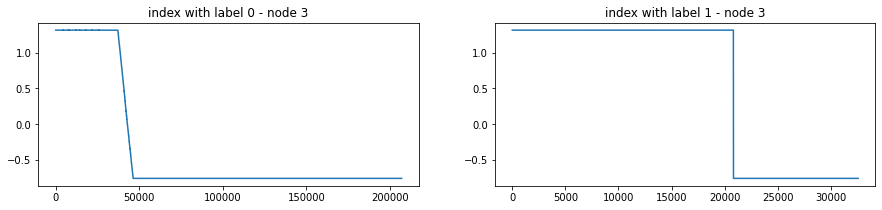

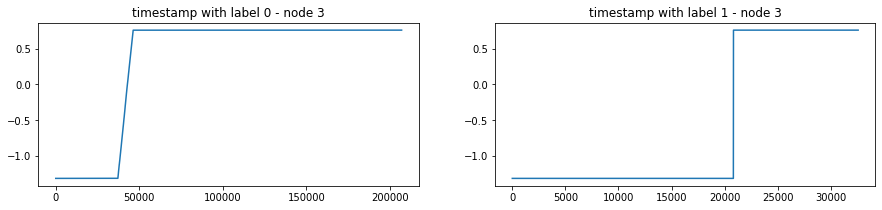

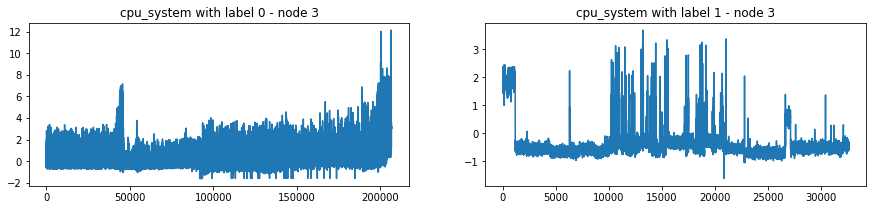

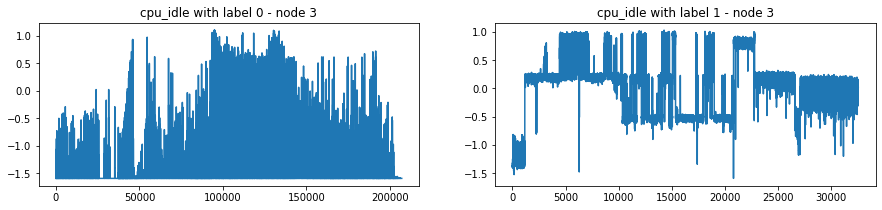

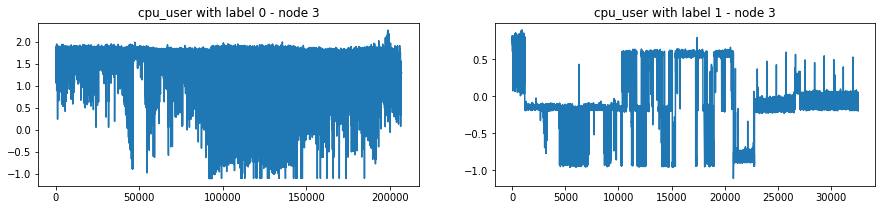

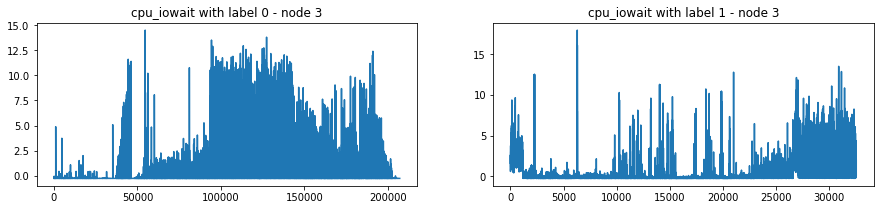

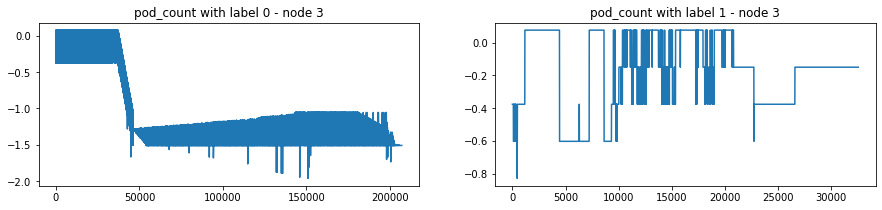

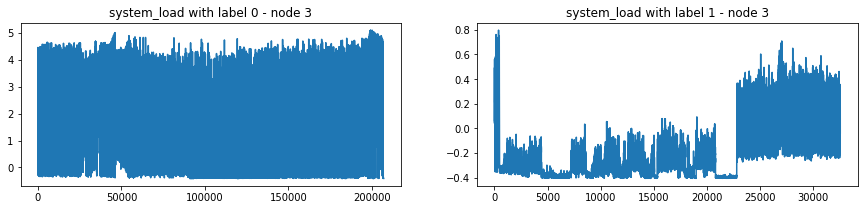

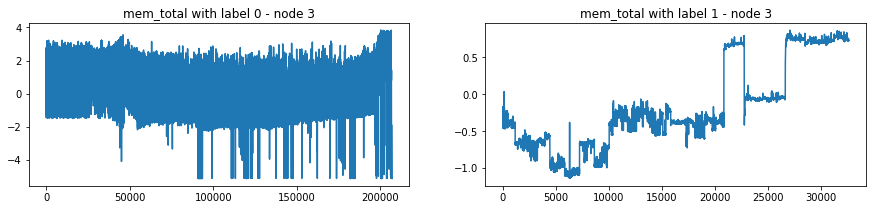

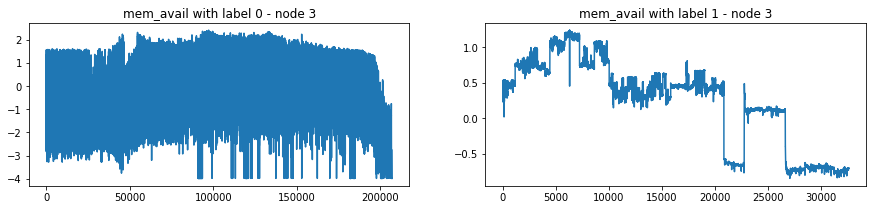

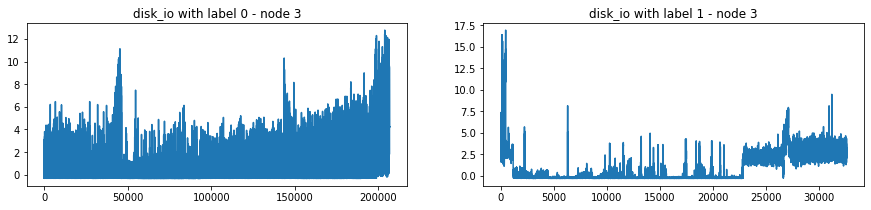

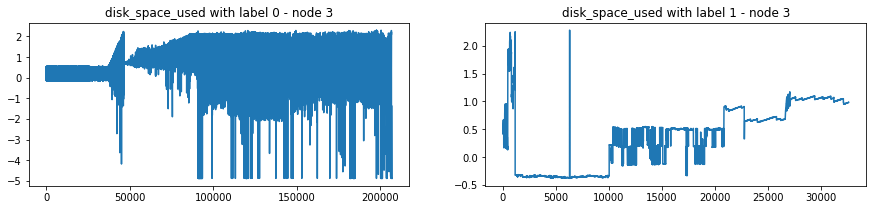

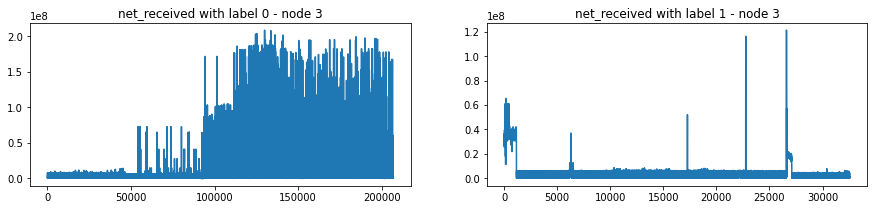

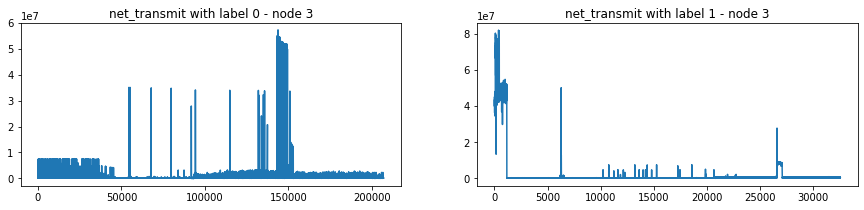

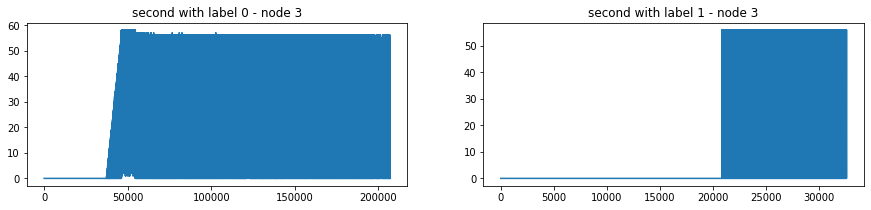

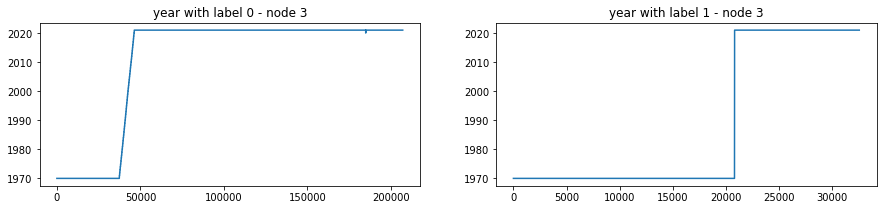

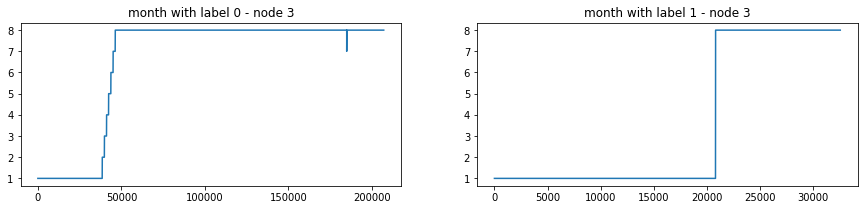

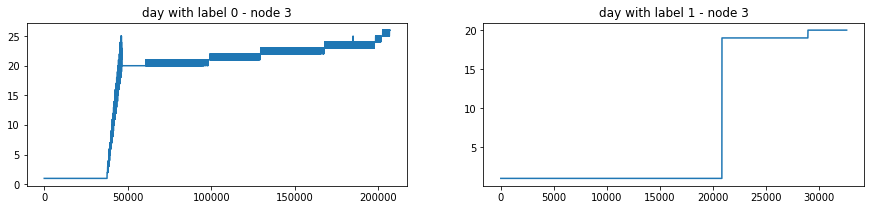

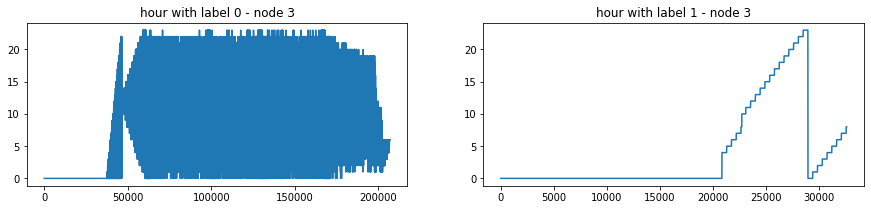

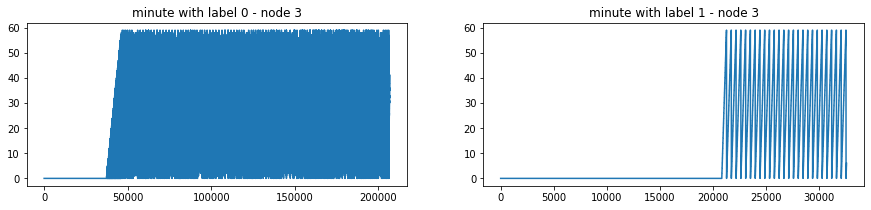

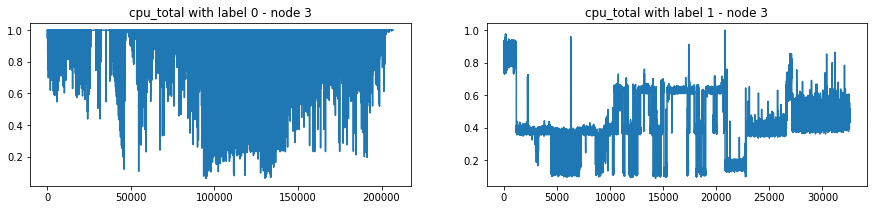

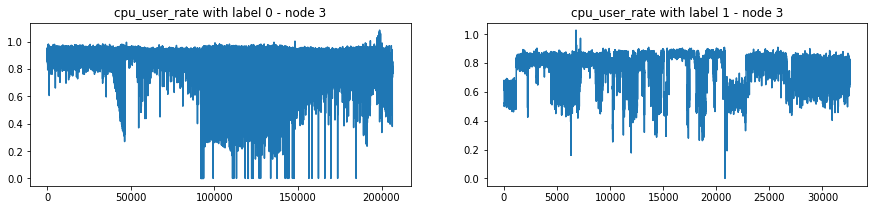

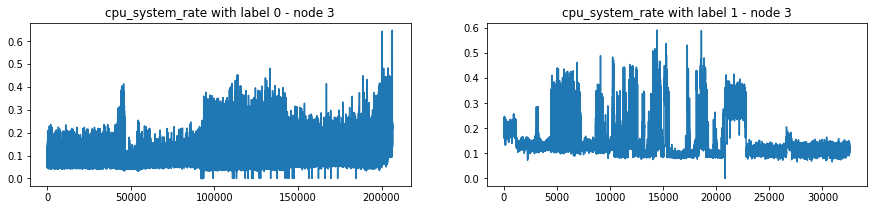

In [24]:
viewAllMetricsByNode(rsDataset,3)

<AxesSubplot:>

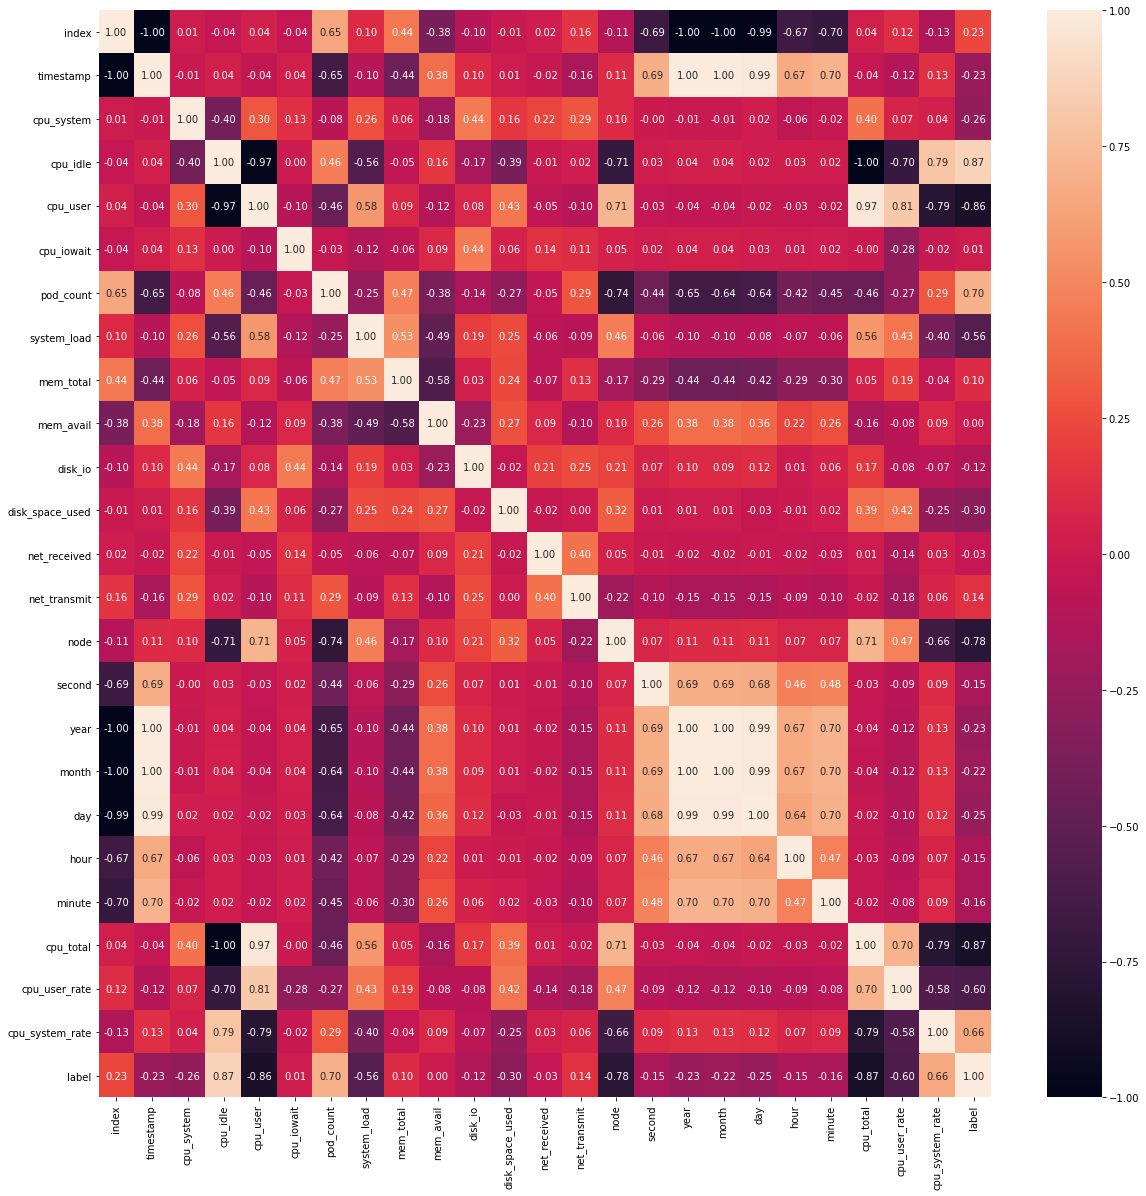

In [25]:
plt.figure(figsize=(20,20))
sn.heatmap(rsDataset.corr(), annot=True, fmt='.2f')

# Split dataset

In [69]:
def splitDataSet(datasetnorms, testSplitPercent):
    #testSplitPercent = 10
    data0 = datasetnorms[datasetnorms["label"]==0]
    data1 = datasetnorms[datasetnorms["label"]==1]
    countAll = datasetnorms["label"].value_counts()
    countAll0 = countAll[0]
    countAll1 = countAll[1]
    countTest0 = int(countAll0 * testSplitPercent / 100 )
    countTest1 = int(countAll1 * testSplitPercent / 100 )
    print("test-0:",countTest0," test-1",countTest1)

    dataTest0 = data0.tail(countTest0)
    dataTest1 = data1.tail(countTest1)

    dataTrain0 = data0.head(-countTest0)
    dataTrain1 = data1.head(-countTest1)
    print("All-0",countAll0," All-1",countAll1)
    print("test-0:",dataTest0["label"].value_counts()[0]," test-1",dataTest1["label"].value_counts()[1])
    print("train-0:",dataTrain0["label"].value_counts()[0]," train-1",dataTrain1["label"].value_counts()[1])

    dataTrainM = pd.concat([dataTrain0, dataTrain1])
    dataTestM = pd.concat([dataTest0, dataTest1])
    print("MergeTrain:")
    print(dataTrainM["label"].value_counts())

    print("MergeTest:")
    print(dataTestM["label"].value_counts())
    
    dataTrainMX = dataTrainM.drop("label", axis=1)
#     dataTrainMX = dataTrainMX.values
    dataTrainMY = dataTrainM["label"]
#     dataTrainMY = dataTrainMY.values

    dataTestMX = dataTestM.drop("label", axis=1)
#     dataTestMX = dataTestMX.values
    dataTestMY = dataTestM["label"]
#     dataTestMY = dataTestMY.values

    return (dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY)

In [27]:
datasetnorm = rsDataset

# KNN Simple

In [265]:
nDatasetNormKnn = datasetnorm.drop("year", axis=1).drop("month", axis=1).drop("day", axis=1).drop("hour", axis=1).drop("minute", axis=1).drop("second", axis=1).drop("timestamp", axis=1).drop("node", axis=1).drop("index", axis=1)


In [266]:
nDatasetNormKnn.head()

cpu_system  cpu_idle  cpu_user  cpu_iowait  pod_count  system_load  \
0   -1.101278  1.015298 -0.946661   -0.246918  -0.602814    -0.405678   
1   -1.101278  1.015298 -0.946661   -0.246918  -0.602814    -0.405678   
2   -0.881544  0.985569 -0.968420   -0.146716  -0.602814    -0.405961   
3   -0.881544  0.985569 -0.968420   -0.146716  -0.602814    -0.405961   
4   -1.080013  1.021051 -0.970492   -0.259443  -0.602814    -0.406385   

   mem_total  mem_avail   disk_io  disk_space_used   net_received  \
0  -0.896268   0.987362 -0.310362        -0.704699  951905.066667   
1  -0.896268   0.987362 -0.310362        -0.704699  951905.066667   
2  -0.895753   0.986829 -0.290475        -0.702686  771843.200000   
3  -0.895753   0.986829 -0.290475        -0.702686  771843.200000   
4  -0.896954   0.988074 -0.326271        -0.702682  849244.266667   

    net_transmit  cpu_total  cpu_user_rate  cpu_system_rate  label  
0  899240.000000   0.094000       0.560284         0.255319      1  
1  899240.000000   0.094000       0.560284         0.255319      1  
2  541984.000000   0.104333       0.437700         0.329073      1  
3  541984.000000   0.104333       0.437700         0.329073      1  
4  771101.333333   0.092000       0.489130         0.271739      1

In [310]:
nDatasetNormKnn.shape

(414040, 16)

In [311]:
(dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSet(nDatasetNormKnn, 30)

test-0: 20702  test-1 20702
All-0 207020  All-1 207020
test-0: 20702  test-1 20702
train-0: 186318  train-1 186318
MergeTrain:
1    186318
0    186318
Name: label, dtype: int64
MergeTest:
1    20702
0    20702
Name: label, dtype: int64


In [268]:
def KnnCalculate(trainX,trainY,testSingleX):
    distances = np.linalg.norm(trainX - testSingleX, axis=1)
    k = 1
    nearest_neighbor_ids = distances.argsort()[:k]
    nearest_label = trainY[nearest_neighbor_ids]
    return nearest_label[0]
    
def KnnPredict(trainX,trainY,testX,testY):
    yLs = []
    acs = 0
    acc = 0
    for xi in range(0,len(testX)):
        yn = KnnCalculate(trainX,trainY,testX[xi])
        if yn == testY[xi]:
            acc = acc + 1
        acs = acs + 1 
        yLs.append(yn)
#     print(yLs)
#     print(testY)
    accuracy = acc / acs
    return (accuracy)
# new_data_point = np.array([[0.569552,0.446407,0.154437,1.016849,0.439051,0.222526,0.291208],[0.569552,0.446407,0.154437,1.016849,0.439051,0.222526,0.291208]])    
# KnnPredict(X,y,new_data_point,[9,10])

In [269]:
print("KNN Accuracy")
KnnPredict(dataTrainMX.values, dataTrainMY.values, dataTestMX.values, dataTestMY.values)

KNN Accuracy


0.9877065017872669

# Regression Logic

In [270]:
!pip3 install statsmodels

we should remove all attribute having pvalue < 0.05

The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable.


Ref: 
https://blog.minitab.com/en/adventures-in-statistics-2/how-to-interpret-regression-analysis-results-p-values-and-coefficients
https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a

In [279]:
nDatasetNormKnn = datasetnorm.drop("year", axis=1).drop("month", axis=1).drop("day", axis=1).drop("hour", axis=1).drop("minute", axis=1).drop("second", axis=1).drop("timestamp", axis=1).drop("node", axis=1).drop("index", axis=1)
# nDatasetNormKnn = nDatasetNormKnn.drop("cpu_system", axis=1).drop("mem_avail", axis=1)
# (dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSet(nDatasetNormKnn, 10)
dataTrainMX = nDatasetNormKnn.drop("label", axis=1)
#Drop because p-value > 0.05
dataTrainMX = dataTrainMX.drop("system_load", axis=1).drop("mem_avail", axis=1).drop("mem_total", axis=1).drop("disk_io", axis=1).drop("cpu_iowait", axis=1)
#Drop because coef ~ 0
# dataTrainMX = dataTrainMX.drop("net_transmit", axis=1)
dataTrainMY = nDatasetNormKnn["label"]
    

In [280]:
import statsmodels.api as sm
logit_model=sm.Logit(dataTrainMY,dataTrainMX)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.001163
         Iterations 17
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.998      
Dependent Variable:  label            AIC:              983.0485   
Date:                2021-08-30 13:52 BIC:              1092.3857  
No. Observations:    414040           Log-Likelihood:   -481.52    
Df Model:            9                LL-Null:          -2.8699e+05
Df Residuals:        414030           LLR p-value:      0.0000     
Converged:           1.0000           Scale:            1.0000     
No. Iterations:      17.0000                                       
-------------------------------------------------------------------
                 Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
cpu_system        1.6279   0.2234   7.2865 0.0000   1.1900   2.0658
cpu_idle          5.5068   1.8759   2.93

In [273]:
# !pip3 install scikit-learn

In [32]:
X_train, X_test, y_train, y_test = train_test_split(dataTrainMX,dataTrainMY, test_size=0.1, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

NameError: name 'dataTrainMX' is not defined

In [284]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78118


In [285]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80     18573
           1       0.83      0.70      0.76     18691

    accuracy                           0.78     37264
   macro avg       0.79      0.78      0.78     37264
weighted avg       0.79      0.78      0.78     37264



# Random Forest Classifier

In [335]:
nDatasetNormKnn = datasetnorm.drop("year", axis=1).drop("month", axis=1).drop("day", axis=1).drop("hour", axis=1).drop("minute", axis=1).drop("second", axis=1).drop("timestamp", axis=1).drop("node", axis=1).drop("index", axis=1)
# (dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSet(nDatasetNormKnn, 10)


In [287]:
modelForestClassifier = RandomForestClassifier(n_estimators=1000)
modelForestClassifier.fit(dataTrainMX, dataTrainMY)

RandomForestClassifier(n_estimators=1000)

In [288]:
y_pred_test = modelForestClassifier.predict(dataTestMX)
print("Accuracy score:",accuracy_score(dataTestMY, y_pred_test))

Accuracy score: 1.0


In [289]:
confusion_matrix(dataTestMY, y_pred_test)

array([[20702,     0],
       [    0, 20702]])

In [290]:
print(classification_report(dataTestMY, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20702
           1       1.00      1.00      1.00     20702

    accuracy                           1.00     41404
   macro avg       1.00      1.00      1.00     41404
weighted avg       1.00      1.00      1.00     41404



In [294]:
from sklearn.tree import export_graphviz
from IPython.display import Image

def drawForestTree(estimator,feature_names,class_names, treeName):
#     fig = plt.figure(figsize=(15, 10))
#     plot_tree(estimator, 
#               feature_names=feature_names,
#               class_names=class_names, 
#               filled=True, impurity=True, 
#               rounded=True)

    
    export_graphviz(estimator, out_file='tree_limited.dot', feature_names = feature_names,
                    class_names = class_names,
                    rounded = True, proportion = False, precision = 2, filled = True)
    !dot -Tpng tree_limited.dot -o tree_limited.png -Gdpi=300

In [295]:
drawForestTree(modelForestClassifier.estimators_[2],list(dataTrainMX.columns.values),["Bad","Good"],"Model Forest Classifier")
Image(filename = 'tree_limited.png')


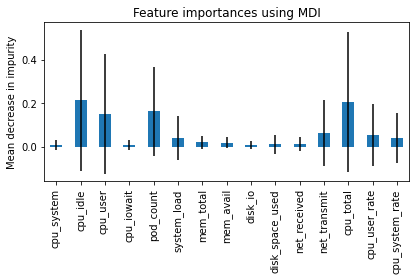

In [296]:
importances = modelForestClassifier.feature_importances_

forest_importances = pd.Series(importances, index=list(dataTrainMX.columns.values))
std = np.std([
    tree.feature_importances_ for tree in modelForestClassifier.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

=> I dont understand why the std of some features are too high

# XGBoost

In [297]:
# !apt-get update -y
# !apt-get install build-essential -y
# !pip3 install cmake --upgrade

In [298]:
# !pip3 install xgboost --upgrade

In [299]:
#In case it does not work
# !rm -rf /root/.local/lib/python3.6/site-packages/xgboost
# !rm -rf xgboost
# !git clone --recursive https://github.com/dmlc/xgboost.git
# !cd xgboost && make
# !cd xgboost/python-package && python3 setup.py install --user

In [196]:
import xgboost

In [273]:
datasetnorm = normalizeColumn(dataset)

0   index
1   timestamp
2   cpu_system
3   cpu_idle
4   cpu_user
5   cpu_iowait
6   pod_count
7   system_load
8   mem_total
9   mem_avail
10   disk_io
11   disk_space_used
12   net_received
13   net_transmit


In [276]:
nDatasetNormKnn = datasetnorm.drop("year", axis=1).drop("month", axis=1).drop("day", axis=1).drop("hour", axis=1).drop("minute", axis=1).drop("second", axis=1).drop("timestamp", axis=1).drop("node", axis=1).drop("index", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("cpu_system", axis=1).drop("cpu_idle", axis=1).drop("cpu_user", axis=1).drop("cpu_iowait", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("cpu_user_rate", axis=1).drop("cpu_system_rate", axis=1).drop("cpu_total", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("pod_count", axis=1).drop("disk_space_used", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("mem_used", axis=1).drop("mem_used_rate", axis=1).drop("mem_avail_rate", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("mem_total", axis=1).drop("mem_avail", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("net_received", axis=1).drop("net_transmit", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("system_load", axis=1).drop("disk_io", axis=1)


In [277]:
list(nDatasetNormKnn.columns.values)

['label',
 'cpu_system_bg',
 'cpu_total_bg',
 'cpu_idle_bg',
 'cpu_user_bg',
 'cpu_iowait_bg',
 'disk_space_used_bg',
 'pod_count_bg',
 'mem_used_rate_bg',
 'net_received_bg',
 'net_transmit_bg',
 'disk_io_bg',
 'system_load_bg']

In [278]:
nDatasetNormKnn

label  cpu_system_bg  cpu_total_bg  cpu_idle_bg  cpu_user_bg  \
0           1              1             1            5            1   
1           1              1             1            5            1   
2           1              1             1            5            1   
3           1              1             1            5            1   
4           1              1             1            5            1   
...       ...            ...           ...          ...          ...   
295507      0              0             5            0            0   
295508      0              0             5            0            0   
295509      0              0             5            0            0   
295510      0              0             5            0            0   
295511      0              0             5            0            0   

        cpu_iowait_bg  disk_space_used_bg  pod_count_bg  mem_used_rate_bg  \
0                   1                   3             2                 3   
1                   1                   3             2                 3   
2                   1                   3             2                 3   
3                   1                   3             2                 3   
4                   0                   3             2                 3   
...               ...                 ...           ...               ...   
295507              0                   0             1                 0   
295508              0                   0             1                 0   
295509              0                   0             1                 0   
295510              0                   0             1                 0   
295511              0                   0             1                 0   

        net_received_bg  net_transmit_bg  disk_io_bg  system_load_bg  
0                     1                1           1               1  
1                     1                1           1               1  
2                     1                1           1               1  
3                     1                1           1               1  
4                     1                1           1               1  
...                 ...              ...         ...             ...  
295507                0                0           0               0  
295508                0                0           0               0  
295509                0                0           0               0  
295510                0                0           0               0  
295511                0                0           0               0  

[295512 rows x 13 columns]

In [279]:
rsDataset = resampleData(nDatasetNormKnn, "label")

In [280]:
list(rsDataset.columns.values)

['cpu_system_bg',
 'cpu_total_bg',
 'cpu_idle_bg',
 'cpu_user_bg',
 'cpu_iowait_bg',
 'disk_space_used_bg',
 'pod_count_bg',
 'mem_used_rate_bg',
 'net_received_bg',
 'net_transmit_bg',
 'disk_io_bg',
 'system_load_bg',
 'label']

In [281]:
rsDataset

cpu_system_bg  cpu_total_bg  cpu_idle_bg  cpu_user_bg  cpu_iowait_bg  \
0                   1             1            5            1              1   
1                   1             1            5            1              1   
2                   1             1            5            1              1   
3                   1             1            5            1              1   
4                   1             1            5            1              0   
...               ...           ...          ...          ...            ...   
478841              1             5            1            5              1   
478842              1             5            0            5              0   
478843              1             5            0            5              0   
478844              1             3            3            2              1   
478845              1             5            0            5              0   

        disk_space_used_bg  pod_count_bg  mem_used_rate_bg  net_received_bg  \
0                        3             2                 3                1   
1                        3             2                 3                1   
2                        3             2                 3                1   
3                        3             2                 3                1   
4                        3             2                 3                1   
...                    ...           ...               ...              ...   
478841                   5             1                 3                1   
478842                   4             1                 3                1   
478843                   4             2                 4                1   
478844                   4             1                 3                1   
478845                   4             2                 4                1   

        net_transmit_bg  disk_io_bg  system_load_bg  label  
0                     1           1               1      1  
1                     1           1               1      1  
2                     1           1               1      1  
3                     1           1               1      1  
4                     1           1               1      1  
...                 ...         ...             ...    ...  
478841                1           1               1      0  
478842                1           1               2      0  
478843                1           1               3      0  
478844                1           1               1      0  
478845                1           1               4      0  

[478846 rows x 13 columns]

In [282]:
print(rsDataset["label"].value_counts())

1    239423
0    239423
Name: label, dtype: int64


In [283]:
def splitDataSetSKLearn(datasetnorms, testSplitPercent):
    dataAllX = datasetnorms.drop("label", axis=1)
    dataAllY = datasetnorms["label"]
    X_train, X_test, y_train, y_test = train_test_split(dataAllX, dataAllY, test_size=testSplitPercent)
    print("splitDataSet with sklearn")
    print("Train")
    print(X_train.shape)
    print("Train labels")
    print(y_train.value_counts())
    print("Test")
    print(X_test.shape)
    print("Test labels")
    print(y_test.value_counts())
    print("All")
    print(dataAllX.shape)
    return (dataAllX,dataAllY,X_train,y_train,X_test,y_test)
# splitDataSetSKLearn(nDatasetNormKnn,70)

In [304]:
(dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSetSKLearn(rsDataset, 0.9999)

splitDataSet with sklearn
Train
(47, 12)
Train labels
1    25
0    22
Name: label, dtype: int64
Test
(478799, 12)
Test labels
0    239401
1    239398
Name: label, dtype: int64
All
(478846, 12)


In [305]:
modelXGboost = xgboost.XGBRFClassifier(n_estimators=100,objective='binary:logistic')
modelXGboost.fit(dataTrainMX.to_numpy(), dataTrainMY.to_numpy())

[12:09:09] WARNING: /tmp/pip-build-5iihhz2k/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=6, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

In [293]:
featureList = list(dataTrainMX.columns.values)

In [306]:
y_pred = modelXGboost.predict(dataTestMX.to_numpy())
print("Accuracy score:",accuracy_score(dataTestMY, y_pred))

Accuracy score: 0.9291936699951336


In [301]:
y_pred

array([0, 0, 0, ..., 0, 1, 1])

In [306]:
#!apt-get install graphviz -y
# from xgboost import plot_tree

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

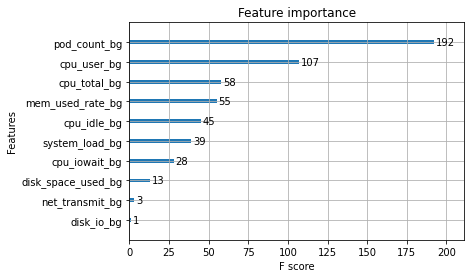

In [302]:
modelXGboost.get_booster().feature_names = featureList
xgboost.plot_importance(modelXGboost.get_booster())

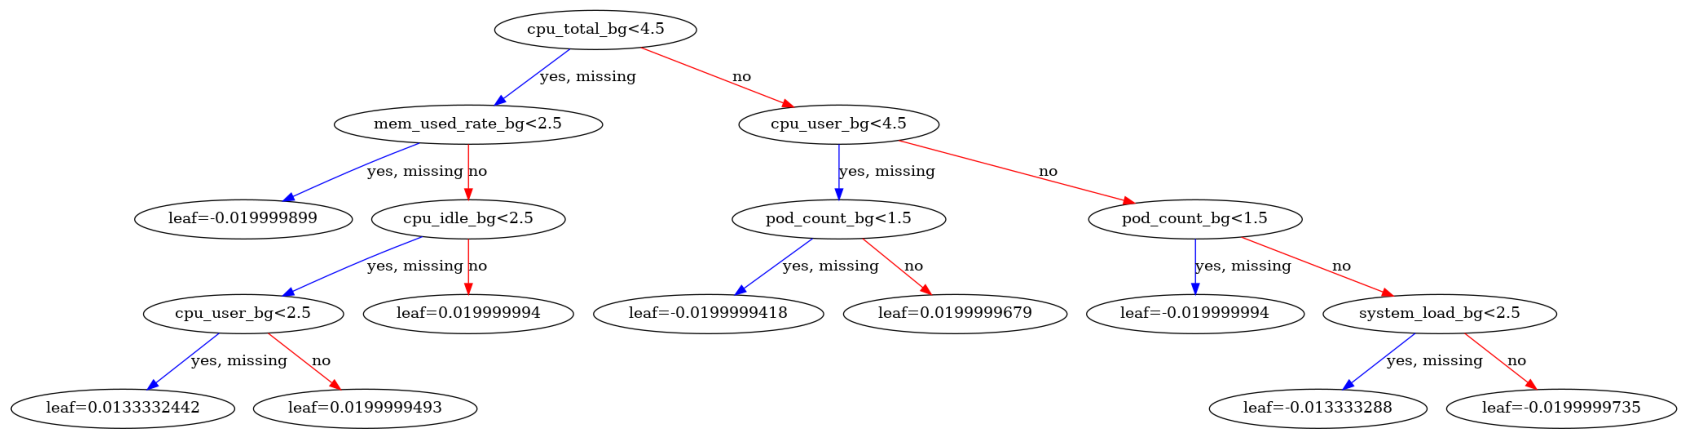

In [303]:
# plot_tree(modelXGboost)
# plt.figure(figsize=(200,200))  # set plot size (denoted in inches)
# plt.show()

fig, ax = plt.subplots(figsize=(30, 30))
xgboost.plot_tree(modelXGboost, num_trees=10, ax=ax)
plt.show()

Attribute leaf is the predicted value. In other words, if the evaluation of a tree model ends at that terminal node (aka leaf node), then this is the value that is returned.

For class 1 probability 1/(1+np.exp(-1* leaf_value))

leaf_value < 0 => Class 0

leaf_value > 0 => Class 1


# Result discussion

Simple KNN: 98% => Its super slow in both training and prediction

Regression Logic: 75% => Training fast

Random Forest Classifier: 100% => Training slow

XGBoost: 99% => Training fast

=> Problem of overfitting ?

In [51]:
adriana.motter@comune.trento.it

cross validation => k fold : 20% test and 80% train
=> 5 fold 

SyntaxError: invalid syntax (<ipython-input-51-c87f40fd3b2a>, line 3)